## QC and Fine Grain Clustering of T Cells

In [1]:
library(Seurat)
library(dplyr)
library(ggplot2)
library(tidyr)
library(viridis)
library(stringr)
library(pheatmap)
library(presto)
library(pals)
library(harmony)
library(singlecellmethods)
library(lisi)
library(symphony)
source("/data/srlab/ik936/Foxxy/utils/utils.R")
source("/data/srlab/anathan/scripts/scseq_utils.R")
library(parallel)

Warning message:
“package ‘Seurat’ was built under R version 4.1.3”
Attaching SeuratObject

Attaching sp

Warning message:
“package ‘dplyr’ was built under R version 4.1.3”

Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Warning message:
“package ‘ggplot2’ was built under R version 4.1.3”
Warning message:
“package ‘tidyr’ was built under R version 4.1.2”
Loading required package: viridisLite

Loading required package: Rcpp

Warning message:
“package ‘Rcpp’ was built under R version 4.1.3”
Loading required package: data.table

Warning message:
“package ‘data.table’ was built under R version 4.1.1”

Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last



Attaching package: ‘pals’


The following objects are masked from ‘package:viridis’:

    cividis, inferno, magma, plasma, t

In [2]:
plot_clusters3 <- function(cluster_ids, labels, pt_size = 20, umap_use = umap_post,
                           do_labels = FALSE,
                           do_points = TRUE, do_density = FALSE, alpha_pt = 1, min_cluster_size = 20) {
    cluster_table <- table(cluster_ids)
    clusters_keep <- names(which(cluster_table > min_cluster_size))
    plt_df <- umap_use %>% data.frame() %>% cbind(cluster = factor(cluster_ids)) %>% cbind(cluster_label = labels)
    factor_levels <- plt_df %>% select(cluster_label, cluster) %>% unique() %>% arrange(as.numeric(cluster)) %>% pull(cluster_label)
    plt <- plt_df %>%
        dplyr::sample_frac(1L) %>%
        ggplot(aes(hUMAP1, hUMAP2, col = factor(cluster_label, levels = factor_levels), fill = factor(cluster_label, factor_levels)))
    if (do_points)
        plt <- plt + geom_point(alpha = alpha_pt, size = 0.5) + theme_classic()
    if (do_density)
        plt <- plt + geom_density_2d()


    plt <- plt +
     #   theme_tufte() +
#         theme(axis.line = element_line()) +
        guides(color = guide_legend(override.aes = list(size = 6))) +
#         scale_color_manual(values = sample(unique(singler.colors))) +
#         scale_color_manual(values = palette_use) +
        labs(x = "UMAP 1", y = "UMAP 2") +
        theme(plot.title = element_text(hjust = .5))

    if (do_labels)
        plt <- plt + ggrepel::geom_label_repel(data = data.table(plt_df)[, .(hUMAP1 = mean(hUMAP1), hUMAP2 = mean(hUMAP2)), by = .(cluster_label, cluster)], label.size = NA,
                                aes(label = cluster), color = "white", size = 5,  max.overlaps = 15) +
        guides(col = FALSE, fill = FALSE) +
#         scale_fill_manual(values = palette_use) +
        NULL
    return(plt)
}

plot_shuffled_features <- function(ab, umap, exprs, pct) {
    library(viridis)
    max.cutoff = quantile(exprs[ab,], pct)
    min.cutoff = quantile(exprs[ab,], 1-pct)
    
    tmp <- sapply(X = exprs[ab,], FUN = function(x) {
        return(ifelse(test = x > max.cutoff, yes = max.cutoff,
            no = x))
    })
    tmp <- sapply(X = tmp, FUN = function(x) {
        return(ifelse(test = x < min.cutoff, yes = min.cutoff,
            no = x))
    })
    umap_res_plot <- cbind(umap, tmp)
    return(ggplot(data = as.data.frame(umap_res_plot)[sample(nrow(umap_res_plot)),] , aes(x = V1, y = V2)) +
      geom_point(mapping = aes(color = tmp), size = 0.75) +
      scale_color_viridis(option = "inferno", end = pct) +
      theme_classic() +
      theme(plot.title = element_text(size = 15), legend.position = "none") +
      labs(title = ab, x = 'hUMAP1', y = 'hUMAP2', color = "Normalized Expression"))
}
                           fig.size <- function (height, width) {
    options(repr.plot.height = height, repr.plot.width = width, repr.plot.res = 300)
}

## READ IN FILES

In [4]:
t_nk_norm <- readRDS('/data/srlab/ssg34/SLE_kidney_v2/data/qcd/T_NK_clusterQCd_norm_09092022.rds')
t_meta <- readRDS('/data/srlab/ssg34/SLE_kidney_v2/data/qcd/T_refmapped_RA_preqc_10252022.rds')
t_norm <- t_nk_norm[, t_meta$cell]
saveRDS(t_norm, '/data/srlab/ssg34/SLE_kidney_v2/data/qcd/T_refmapped_RA_preqc_nomr_10252022.rds')

## QC Clustering

In [8]:
genes_exclude <- c(grep("^MT-|^RPL|^RPS|MALAT1|MIR-", row.names(qcd_norm), value = TRUE), Seurat::cc.genes$s.genes, Seurat::cc.genes$g2m.genes) 

In [2]:
nuc_norm <- t_norm[, t_meta %>% filter(dataset == 'snRNAseq') %>% pull(cell)]

sc_norm <- t_norm[, t_meta %>% filter(dataset == 'scRNAseq') %>% pull(cell)]

nuc_meta <- t_meta %>% filter(dataset == 'snRNAseq')

sc_meta <- t_meta %>% filter(dataset == 'scRNAseq')

ERROR: Error in eval(expr, envir, enclos): object 't_norm' not found


In [6]:
## Filtering for expressed genes
threshold_genes <- nuc_norm[rownames(nuc_norm[rowMeans(nuc_norm) >= .01, ]), ]

samples_25 <- nuc_meta %>% group_by(sample) %>% tally() %>% filter(n > 25) %>% pull(sample)

threshold_samples <- threshold_genes[, nuc_meta %>% filter(sample %in% samples_25) %>% pull(cell)]
 
## Variable gene selection — very inefficiently written, but essentially using VST to select most variable genes from samples with > 10 cells
var_genes_raw <- singlecellmethods::vargenes_vst(object = threshold_samples, groups = nuc_meta %>% filter(sample %in% samples_25) %>% pull(sample), topn = 500)

In [10]:
## Scale Data
t_scaled_nuc <- nuc_norm[var_genes_raw[! var_genes_raw %in% genes_exclude], ] %>% scaleData
## PCA
t_pca_res_nuc <- irlba::prcomp_irlba(t(t_scaled_nuc), 20)
## UMAP
t_umap_res_nuc <- uwot::umap(t_pca_res_nuc$x[, 1:20], n_neighbors = 30L, metric = "euclidean", min_dist = .1)

use_weights



[1] FALSE


use_weights

use_weights



[1] FALSE


use_weights

Harmony 1/20

Harmony 2/20

Harmony 3/20

Harmony 4/20

Harmony 5/20

Harmony 6/20

Harmony 7/20

Harmony 8/20

Harmony 9/20

Harmony 10/20

Harmony 11/20

Harmony 12/20

Harmony 13/20

Harmony 14/20

Harmony 15/20

Harmony 16/20

Harmony 17/20

Harmony 18/20

Harmony 19/20

Harmony 20/20



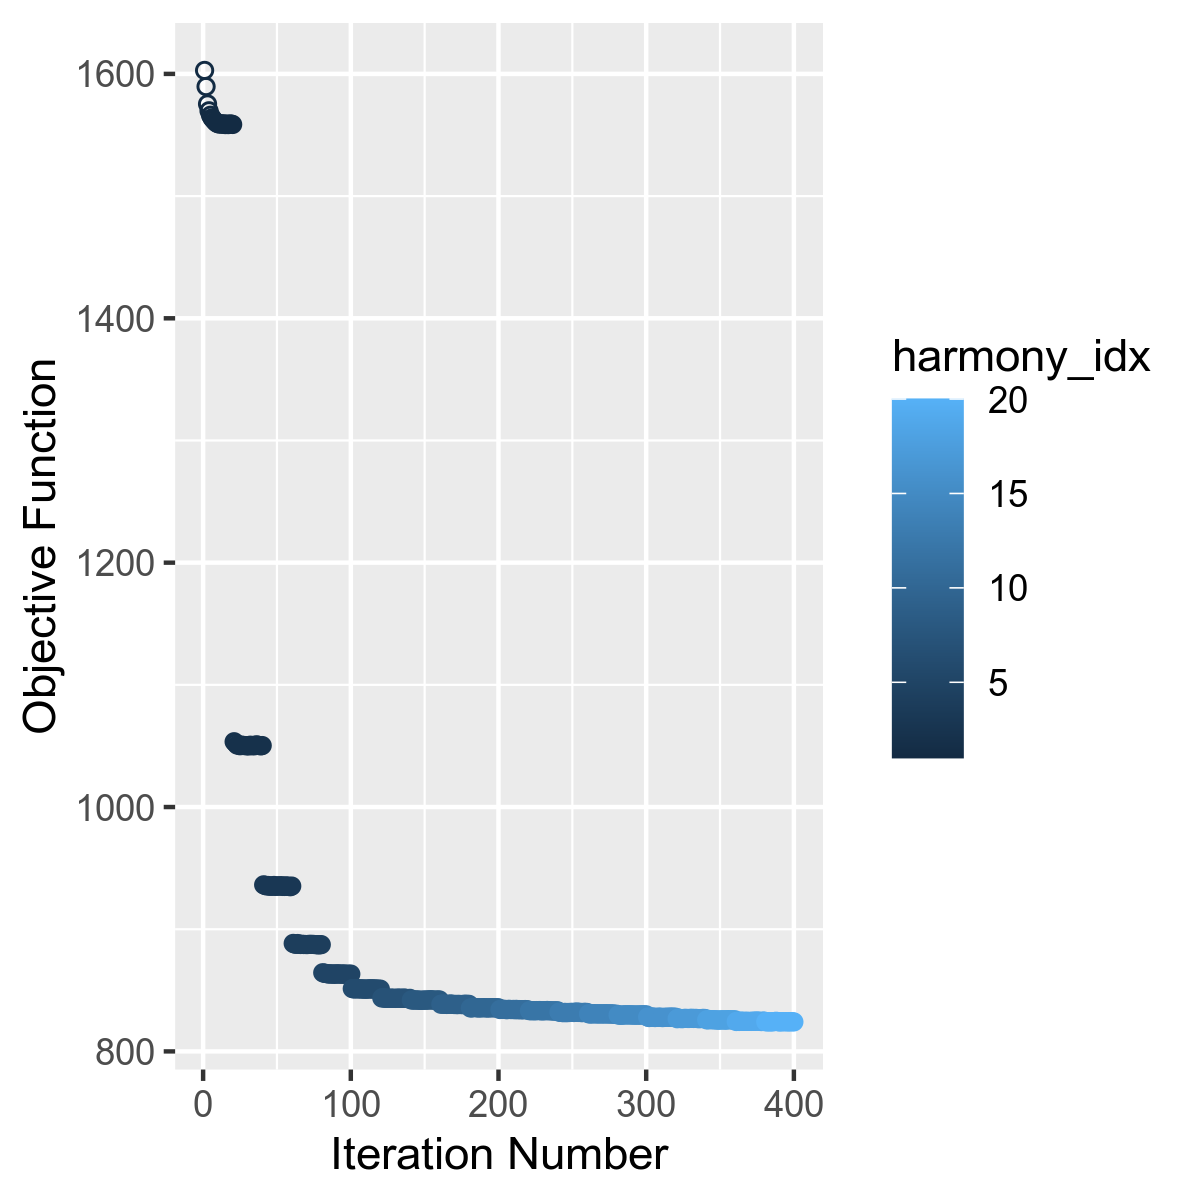

In [51]:
t_harmony_nuc <- HarmonyMatrix(t_pca_res_nuc$x[, 1:20], nuc_meta, 
                                     vars_use = c("sample", "processing.batch", "Site"), 
                        # lambda = 1, 
                        # tau = 0, 
                        epsilon.cluster = -Inf,
                        epsilon.harmony = -Inf,
                        max.iter.cluster = 20,
                        max.iter.harmony = 20,
                        plot_convergence = TRUE,
                        npcs = 20, do_pca = FALSE)

In [60]:
t_humap_res_nuc <- uwot::umap(t_harmony_nuc[, 1:20], n_neighbors = 30L, metric = "euclidean", min_dist = .1)

In [59]:
snn_ref <- BuildSNNSeurat(t_harmony_nuc[,1:20], nn.eps = 0)

resolution_list <- c(2.0)
ids_ref_nuc <- Reduce(cbind, mclapply(resolution_list, function(res_use) {
    Seurat:::RunModularityClustering(SNN = snn_ref, modularity = 1,
        resolution = res_use, algorithm = 1, n.start = 20,
        n.iter = 20, random.seed = 100, print.output = FALSE,
        temp.file.location = NULL, edge.file.name = NULL)
}, mc.preschedule = FALSE, mc.cores = min(20, length(resolution_list)))) 

In [55]:
MYL <- c("AIF1", "LYZ", "FCGR3A", "CD14")

B <- c("MS4A1", "IGHG1", "MZB1")

T <- c("CD2", "CD3D")

EC <- c("ENG", "EGFL7", "EMCN")

IC <- c("ATP6V0D2", "ATP6V1G3", "SLC26A7")

PC_DCT_CNT <- c("CALB1", "FXYD4", "AQP2")

ATL_TAL <- c("SLC12A1", "SFRP1", "EGF")

FIB <- c("COL1A2", "COL1A1", "CCDC80")

POD <- c("PTGDS", "PODXL", "NPHS2")

PT1 <- c("SLC13A3", "SLC34A1", "LRP2")

MAST <- c("TPSB2", "TPSAB1", "CPA3")

pDC <- c('IL3RA', 'JCHAIN', 'NRP1')


In [64]:
nuc_meta <-nuc_meta %>% mutate(Myeloid = colMeans(nuc_norm[rownames(nuc_norm) %in% MYL, ]),
                                        T = colMeans(nuc_norm[rownames(nuc_norm) %in% T, ]), 
                                        B = colMeans(nuc_norm[rownames(nuc_norm) %in% B, ]),
                                        EC = colMeans(nuc_norm[rownames(nuc_norm) %in% EC, ]),
                                        IC = colMeans(nuc_norm[rownames(nuc_norm) %in% IC, ]),
                                        PC = colMeans(nuc_norm[rownames(nuc_norm) %in% PC_DCT_CNT, ]),
                                        ATL = colMeans(nuc_norm[rownames(nuc_norm) %in% ATL_TAL, ]),
                                        Fib = colMeans(nuc_norm[rownames(nuc_norm) %in% FIB, ]),
                                        Pod = colMeans(nuc_norm[rownames(nuc_norm) %in% POD, ]),
                                        PT = colMeans(nuc_norm[rownames(nuc_norm) %in% PT1, ]),
                                        qc_cluster = ids_ref_nuc)

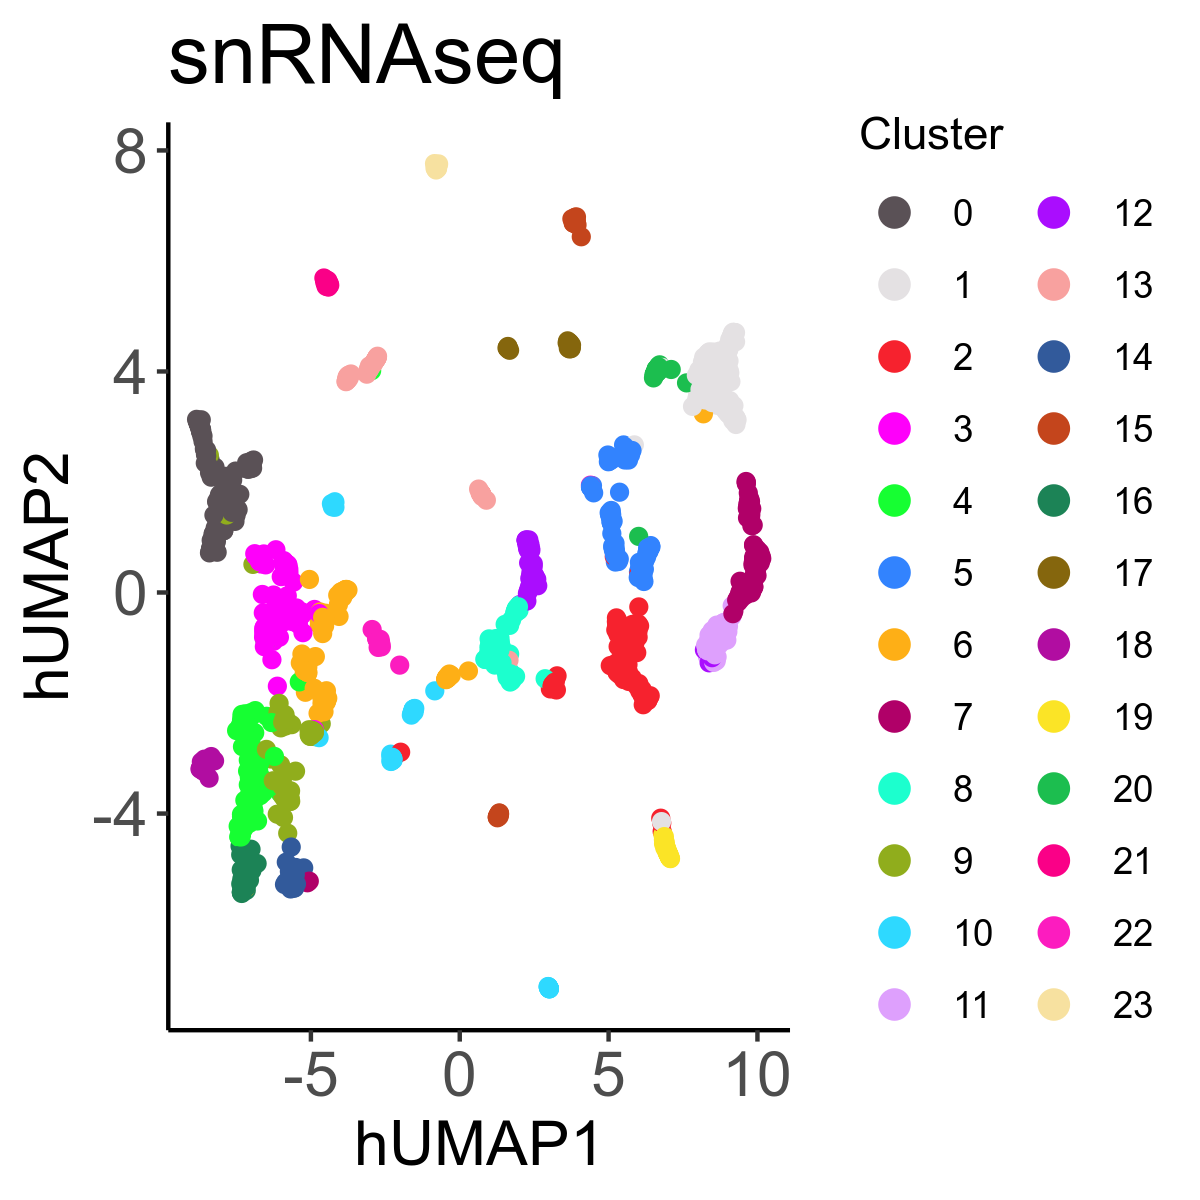

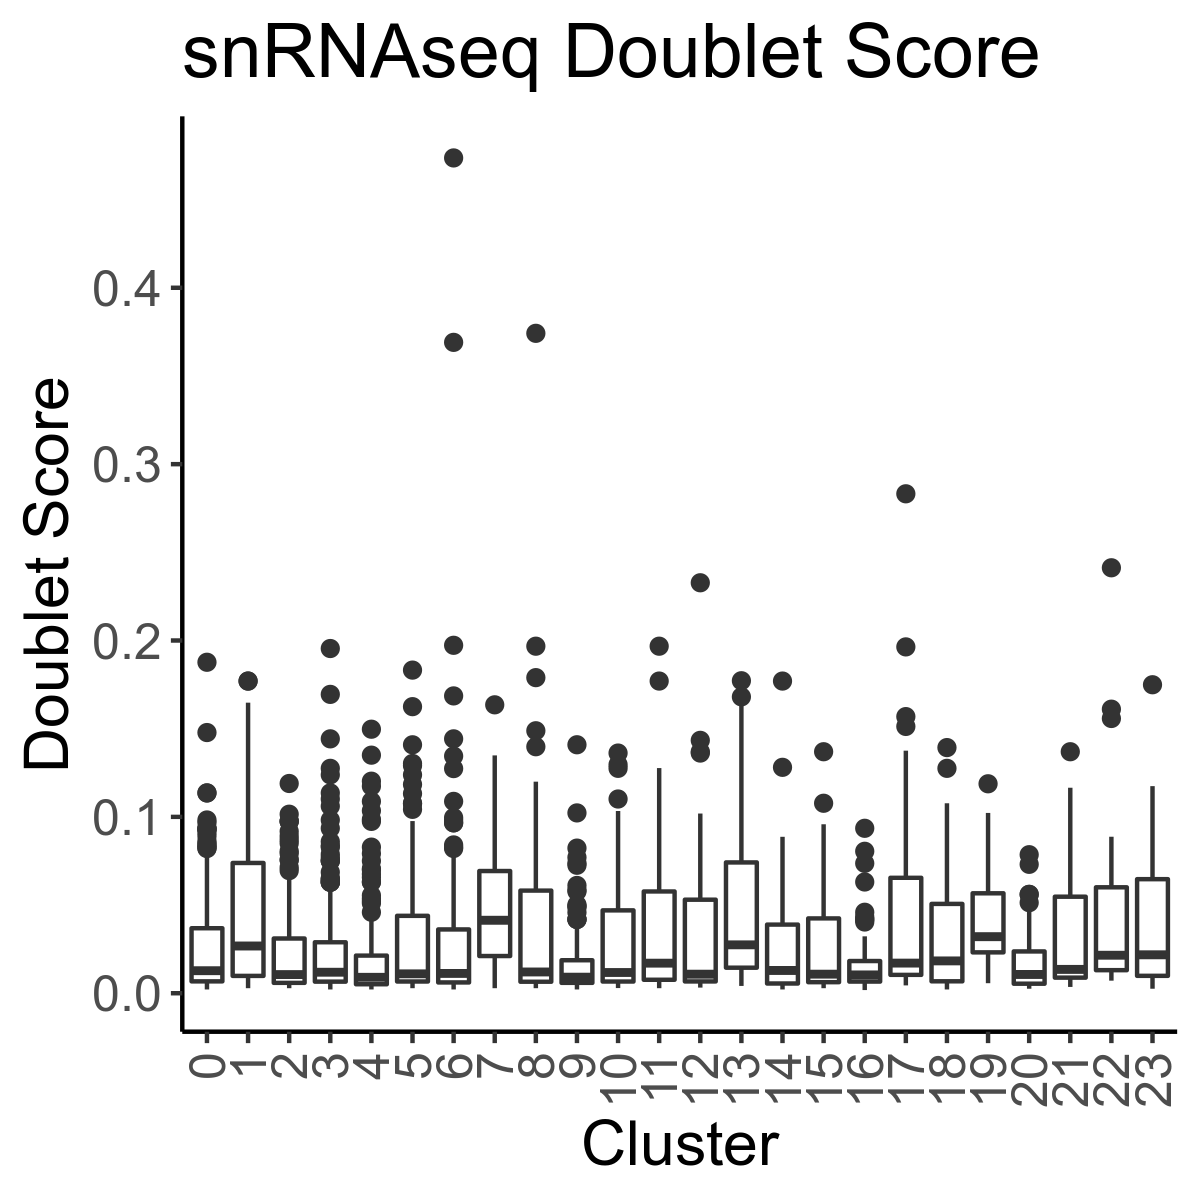

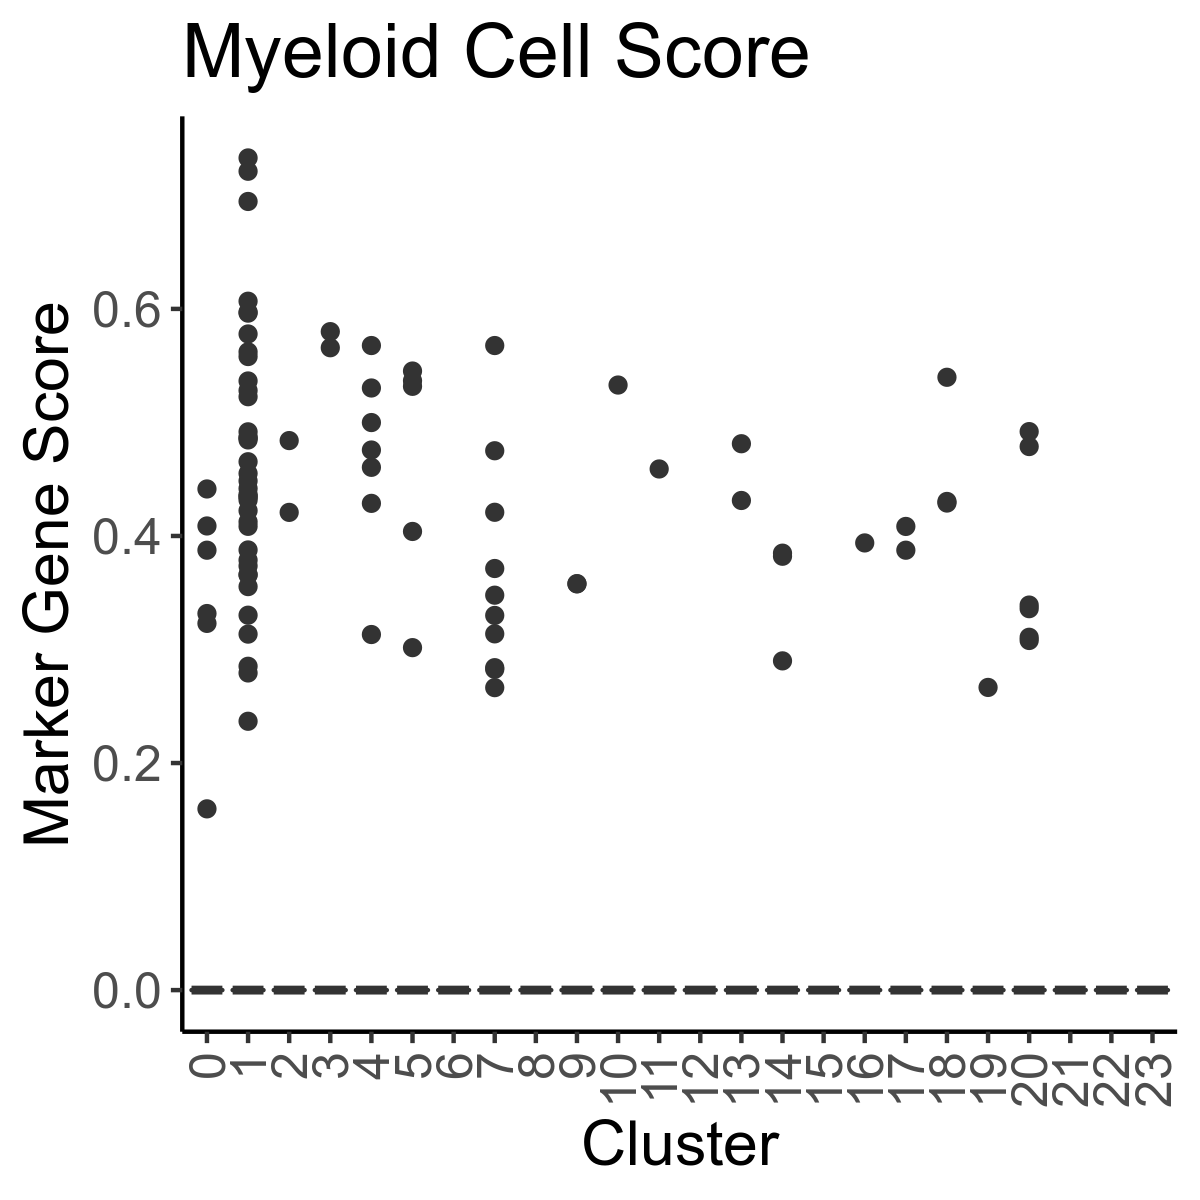

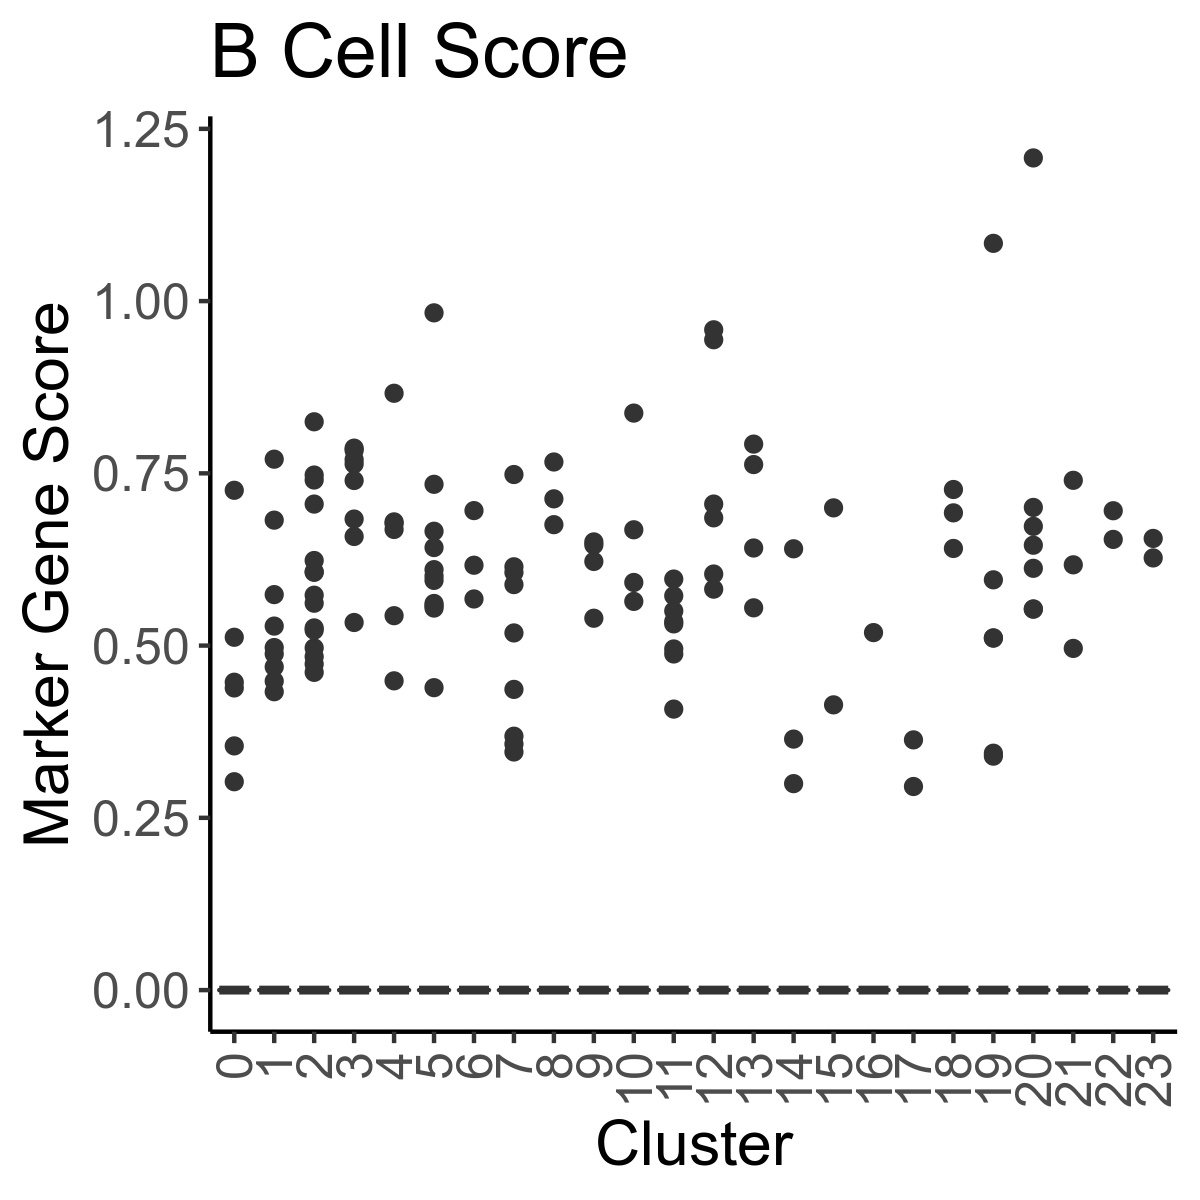

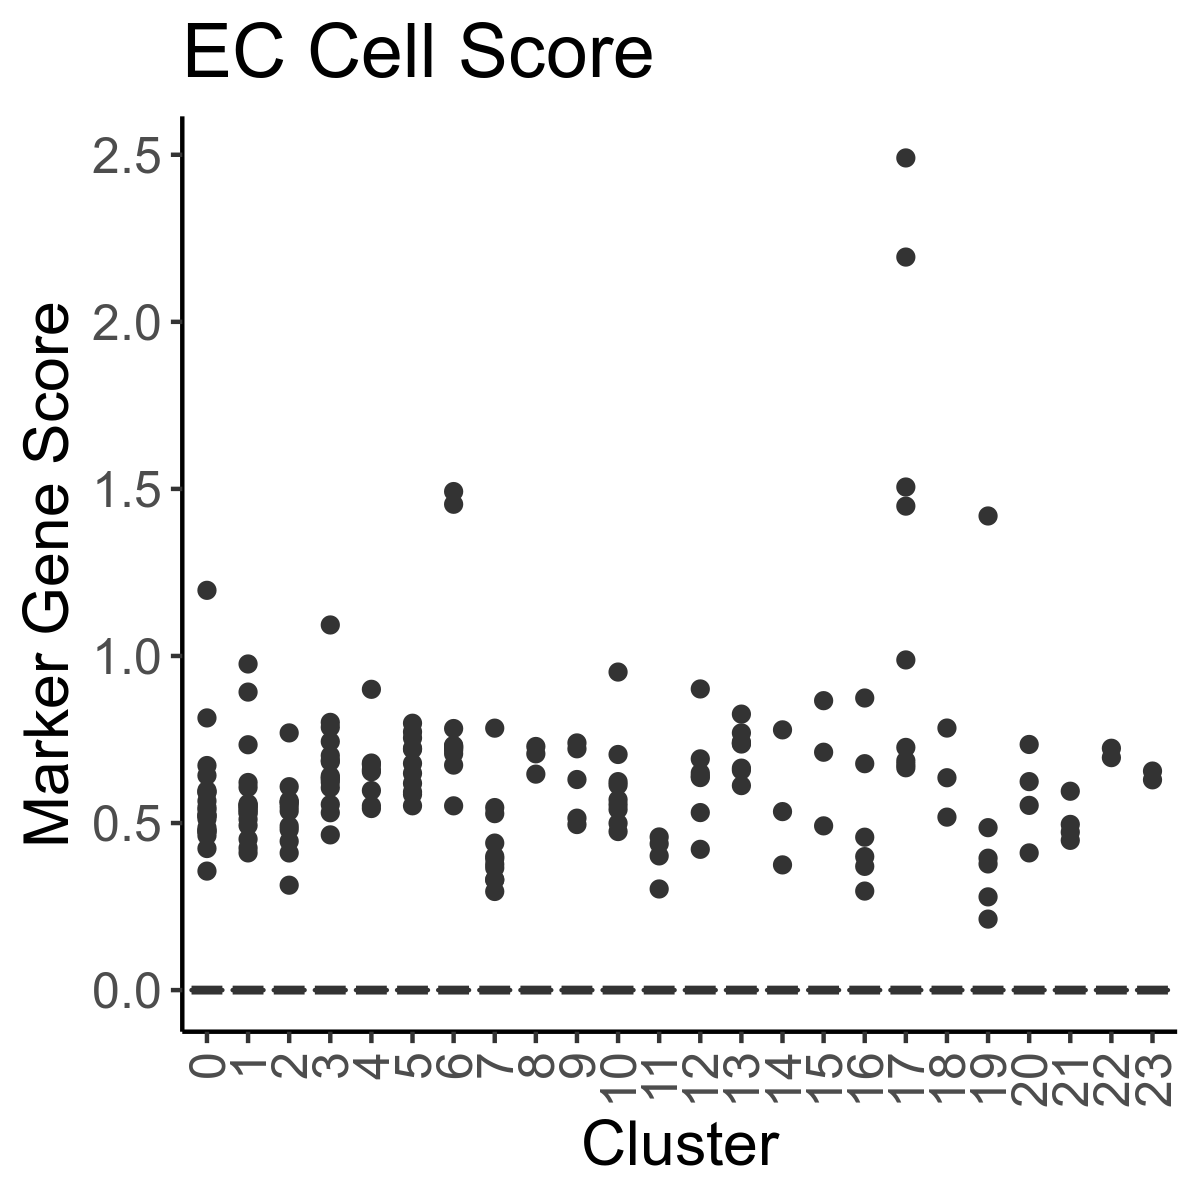

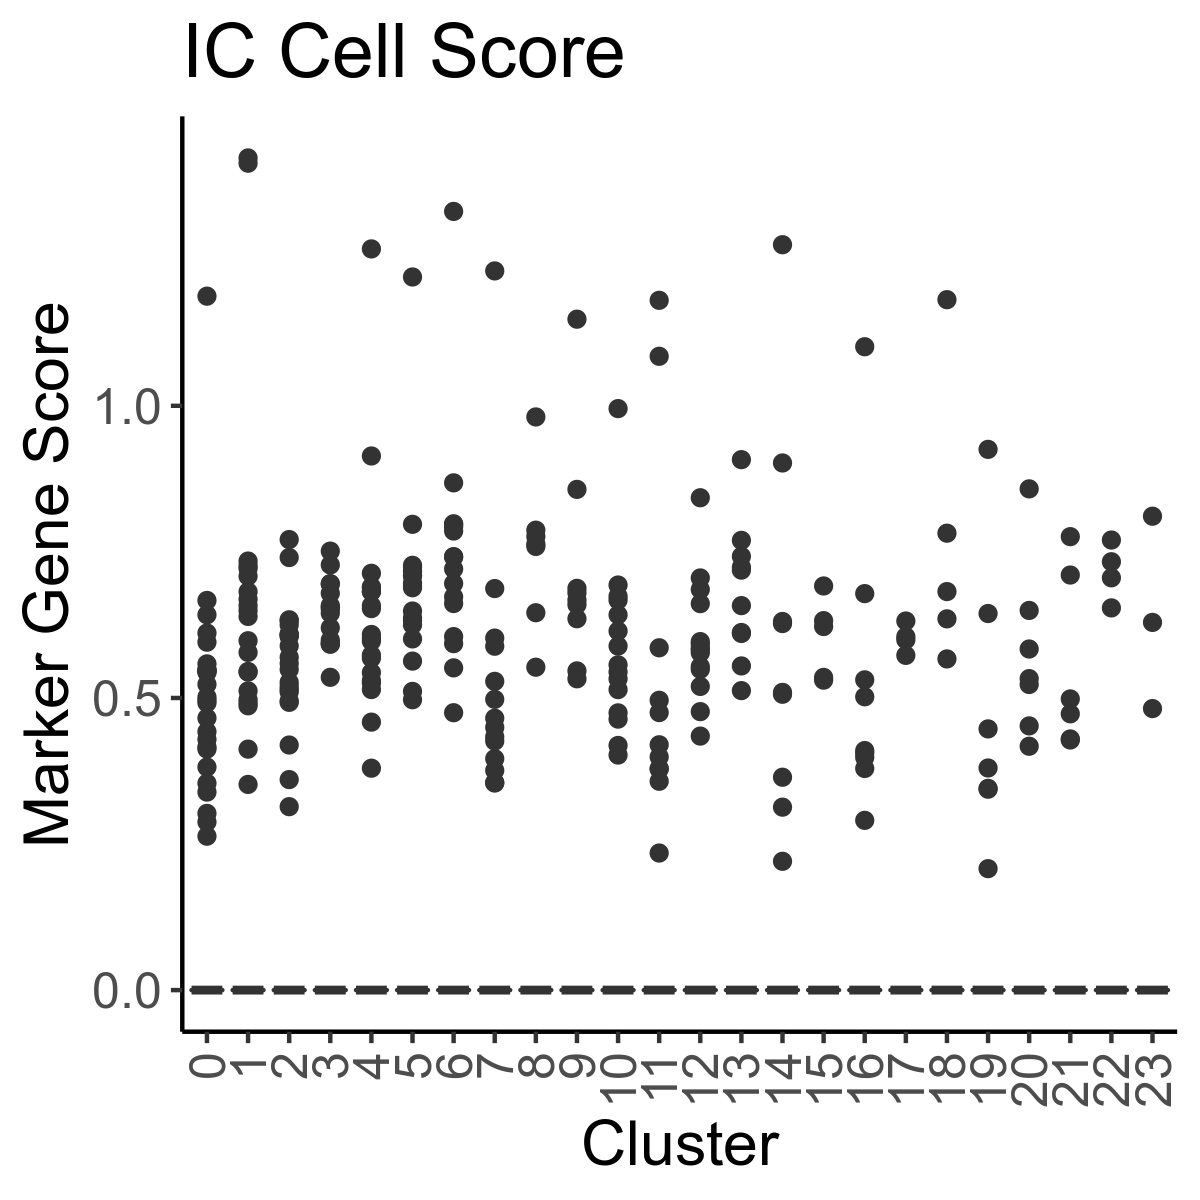

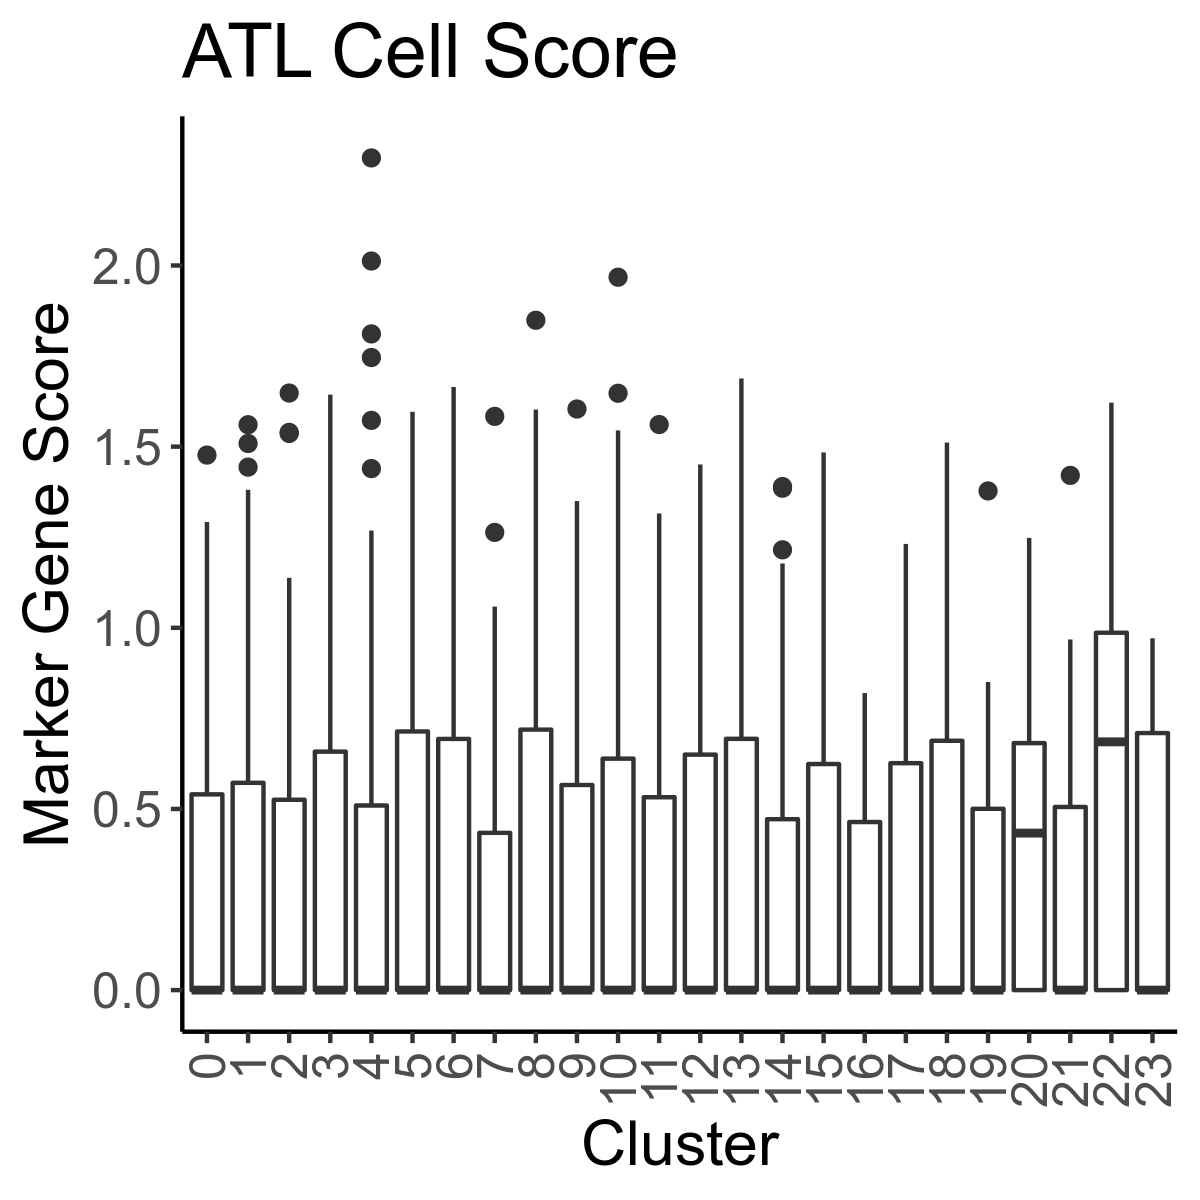

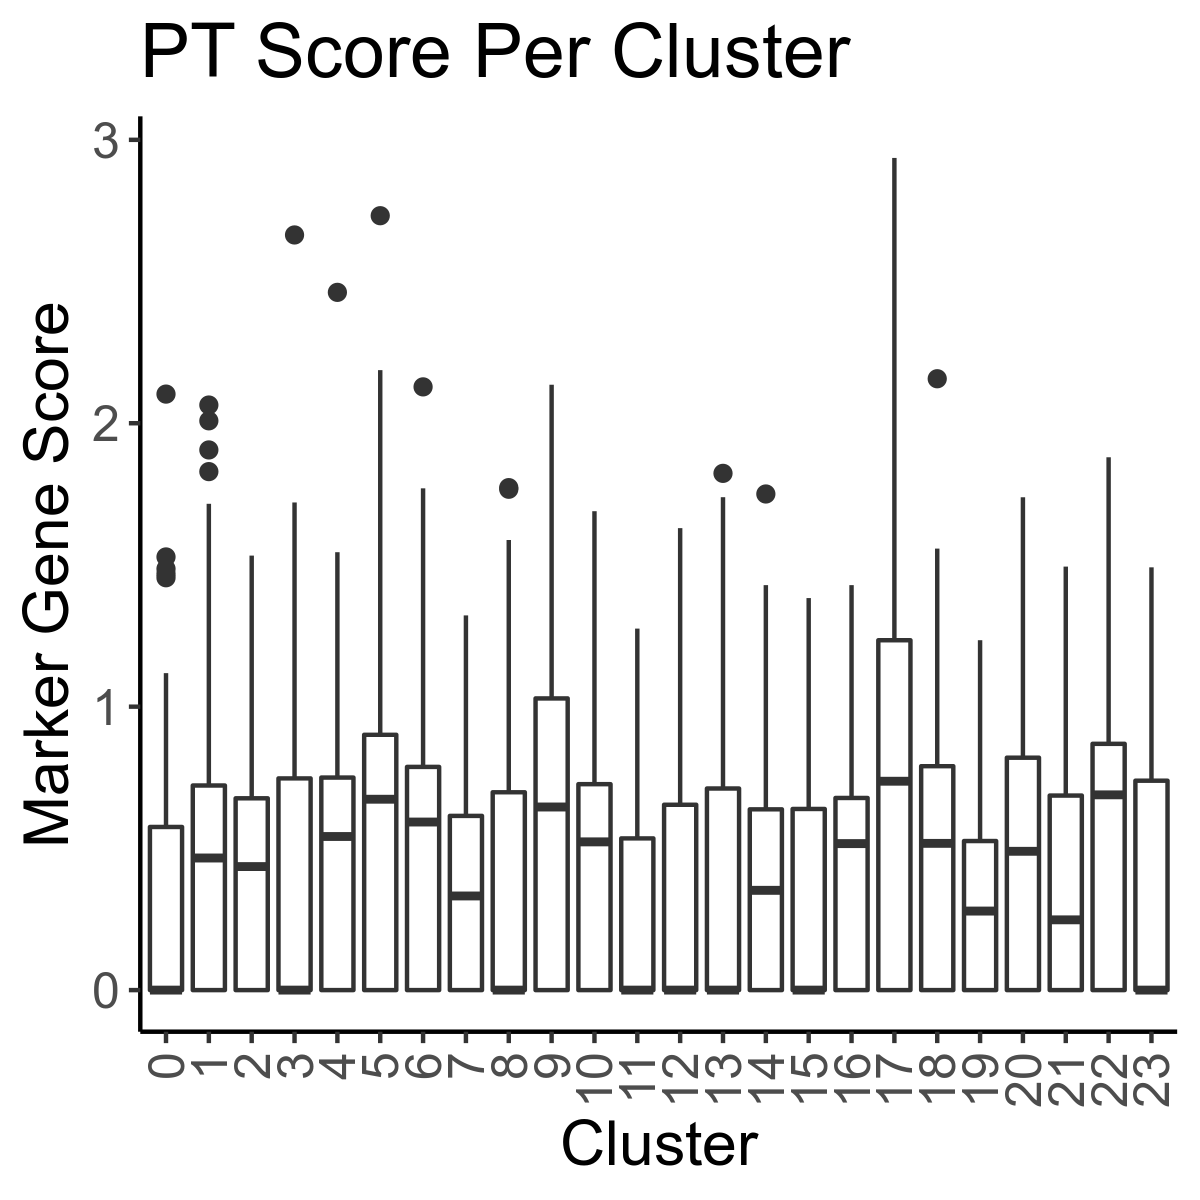

In [65]:
ggplot(nuc_meta %>% mutate(hUMAP1 = t_humap_res_nuc[, 1], 
                           hUMAP2 = t_humap_res_nuc[, 2]), 
                           aes(x = hUMAP1, y = hUMAP2, color = as.factor(qc_cluster))) + 
    geom_point() + 
    theme_classic() +
    scale_color_manual(values = c(as.vector(polychrome(29)), as.vector(alphabet2(7))), drop = FALSE) +
    theme(axis.text = element_text(size = 15), axis.title = element_text(size = 15), plot.title = element_text(size = 20)) +
    labs(title = 'snRNAseq') +
    guides(colour = guide_legend(override.aes = list(size=3), title="Cluster"))



fig.size(4, 4)
ggplot(nuc_meta, aes(x = as.character(qc_cluster), y = doublet_score)) + 
    geom_boxplot() + 
    theme_classic() +
    scale_x_discrete(limits = factor(seq(0, 23))) + 
    theme(axis.text = element_text(size = 12), axis.title = element_text(size = 15), plot.title = element_text(size = 18)) +
    labs(x = 'Cluster', y = 'Doublet Score', title = 'snRNAseq Doublet Score ') +
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))


ggplot(nuc_meta, aes(x = as.character(qc_cluster), y = Myeloid)) + 
    geom_boxplot() + 
    theme_classic() +
    scale_x_discrete(limits = factor(seq(0, 23))) + 
    theme(axis.text = element_text(size = 12), axis.title = element_text(size = 15), plot.title = element_text(size = 18)) +
    labs(x = 'Cluster', y = 'Marker Gene Score', title = 'Myeloid Cell Score') +
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))

ggplot(nuc_meta, aes(x = as.character(qc_cluster), y = B)) + 
    geom_boxplot() + 
    theme_classic() +
    scale_x_discrete(limits = factor(seq(0, 23))) + 
    theme(axis.text = element_text(size = 12), axis.title = element_text(size = 15), plot.title = element_text(size = 18)) +
    labs(x = 'Cluster', y = 'Marker Gene Score', title = 'B Cell Score') + 
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))



ggplot(nuc_meta, aes(x = as.character(qc_cluster), y = EC)) + 
    geom_boxplot() + 
    theme_classic() +
    scale_x_discrete(limits = factor(seq(0, 23))) + 
    theme(axis.text = element_text(size = 12), axis.title = element_text(size = 15), plot.title = element_text(size = 18)) +
    labs(x = 'Cluster', y = 'Marker Gene Score', title = 'EC Cell Score') +
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))

ggplot(nuc_meta, aes(x = as.character(qc_cluster), y = IC)) + 
    geom_boxplot() + 
    theme_classic() +
    scale_x_discrete(limits = factor(seq(0, 23))) + 
    theme(axis.text = element_text(size = 12), axis.title = element_text(size = 15), plot.title = element_text(size = 18)) +
    labs(x = 'Cluster', y = 'Marker Gene Score', title = 'IC Cell Score') +
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))

ggplot(nuc_meta, aes(x = as.character(qc_cluster), y = ATL)) + 
    geom_boxplot() + 
    theme_classic() +
    scale_x_discrete(limits = factor(seq(0, 23))) + 
    theme(axis.text = element_text(size = 12), axis.title = element_text(size = 15), plot.title = element_text(size = 18)) +
    labs(x = 'Cluster', y = 'Marker Gene Score', title = 'ATL Cell Score') +
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))

ggplot(nuc_meta, aes(x = as.character(qc_cluster), y = PT)) + 
    geom_boxplot() + 
    theme_classic() +
    scale_x_discrete(limits = factor(seq(0, 23))) + 
    theme(axis.text = element_text(size = 12), axis.title = element_text(size = 15), plot.title = element_text(size = 18)) +
    labs(x = 'Cluster', y = 'Marker Gene Score', title = 'PT Score Per Cluster') +
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))

In [1]:
## Filtering for expressed genes
threshold_genes <- sc_norm[rownames(sc_norm[rowMeans(sc_norm) >= .01, ]), ]

samples_25 <- sc_meta %>% group_by(sample) %>% tally() %>% filter(n > 25) %>% pull(sample)

threshold_samples <- threshold_genes[, sc_meta %>% filter(sample %in% samples_25) %>% pull(cell)]
 
## Variable gene selection — very inefficiently written, but essentially using VST to select most variable genes from samples with > 10 cells
var_genes_raw <- singlecellmethods::vargenes_vst(object = threshold_samples, groups = sc_meta %>% filter(sample %in% samples_25) %>% pull(sample), topn = 500)

ERROR: Error in eval(expr, envir, enclos): object 'sc_norm' not found


In [67]:
## Scale Data
t_scaled_sc <- sc_norm[var_genes_raw[! var_genes_raw %in% genes_exclude], ] %>% scaleData
## PCA
t_pca_res_sc <- irlba::prcomp_irlba(t(t_scaled_sc), 20)
## UMAP
t_umap_res_sc <- uwot::umap(t_pca_res_sc$x[, 1:20], n_neighbors = 30L, metric = "euclidean", min_dist = .1)

use_weights



[1] FALSE


use_weights

use_weights



[1] FALSE


use_weights

Harmony 1/20

Harmony 2/20

Harmony 3/20

Harmony 4/20

Harmony 5/20

Harmony 6/20

Harmony 7/20

Harmony 8/20

Harmony 9/20

Harmony 10/20

Harmony 11/20

Harmony 12/20

Harmony 13/20

Harmony 14/20

Harmony 15/20

Harmony 16/20

Harmony 17/20

Harmony 18/20

Harmony 19/20

Harmony 20/20



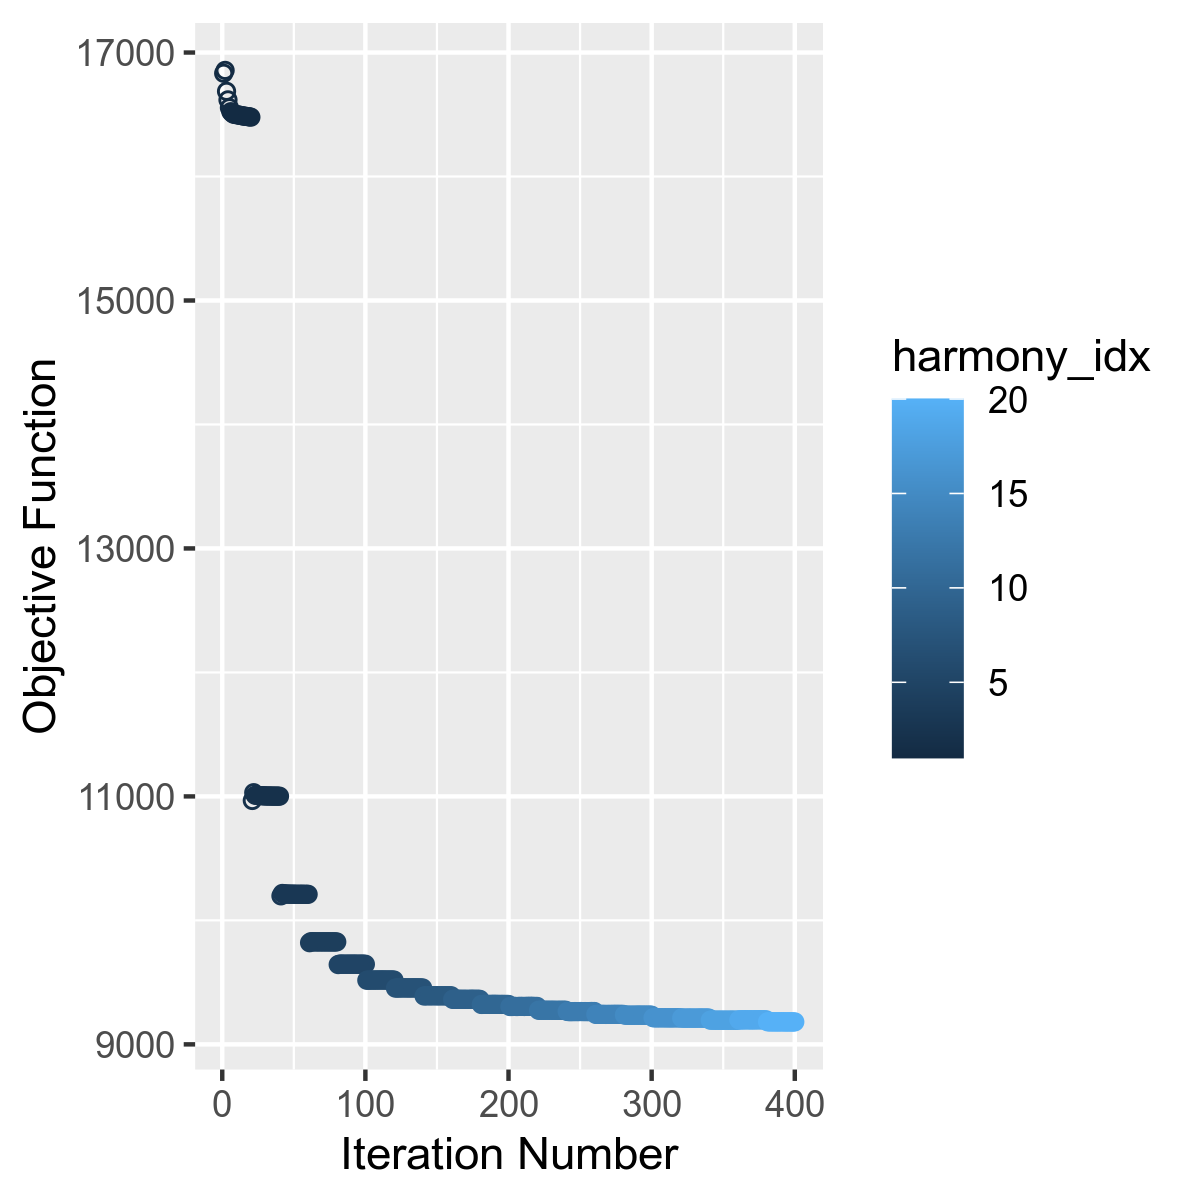

In [68]:
t_harmony_sc <- HarmonyMatrix(t_pca_res_sc$x[, 1:20], sc_meta, 
                                     vars_use = c("sample", "processing.batch", "Site"), 
                        # lambda = 1, 
                        # tau = 0, 
                        epsilon.cluster = -Inf,
                        epsilon.harmony = -Inf,
                        max.iter.cluster = 20,
                        max.iter.harmony = 20,
                        plot_convergence = TRUE,
                        npcs = 20, do_pca = FALSE)

In [70]:
t_humap_res_sc <- uwot::umap(t_harmony_sc[, 1:20], n_neighbors = 30L, metric = "euclidean", min_dist = .1)

In [73]:
snn_ref <- BuildSNNSeurat(t_harmony_sc[,1:20], nn.eps = 0)

resolution_list <- c(2.0)
ids_ref_sc <- Reduce(cbind, mclapply(resolution_list, function(res_use) {
    Seurat:::RunModularityClustering(SNN = snn_ref, modularity = 1,
        resolution = res_use, algorithm = 1, n.start = 20,
        n.iter = 20, random.seed = 100, print.output = FALSE,
        temp.file.location = NULL, edge.file.name = NULL)
}, mc.preschedule = FALSE, mc.cores = min(20, length(resolution_list)))) 

In [85]:
sc_meta <- sc_meta %>% mutate(Myeloid = colMeans(sc_norm[rownames(sc_norm) %in% MYL, ]),
                                        T = colMeans(sc_norm[rownames(sc_norm) %in% T, ]), 
                                        B = colMeans(sc_norm[rownames(sc_norm) %in% B, ]),
                                        EC = colMeans(sc_norm[rownames(sc_norm) %in% EC, ]),
                                        IC = colMeans(sc_norm[rownames(sc_norm) %in% IC, ]),
                                        PC = colMeans(sc_norm[rownames(sc_norm) %in% PC_DCT_CNT, ]),
                                        ATL = colMeans(sc_norm[rownames(sc_norm) %in% ATL_TAL, ]),
                                        Fib = colMeans(sc_norm[rownames(sc_norm) %in% FIB, ]),
                                        Pod = colMeans(sc_norm[rownames(sc_norm) %in% POD, ]),
                                        PT = colMeans(sc_norm[rownames(sc_norm) %in% PT1, ]),
                                        MAST = colMeans(sc_norm[rownames(sc_norm) %in% MAST, ]),
                                        pDC = colMeans(sc_norm[rownames(sc_norm) %in% pDC, ]),
                                        qc_cluster = ids_ref_sc)

Warning message:
“Removed 5 rows containing non-finite values (stat_boxplot).”


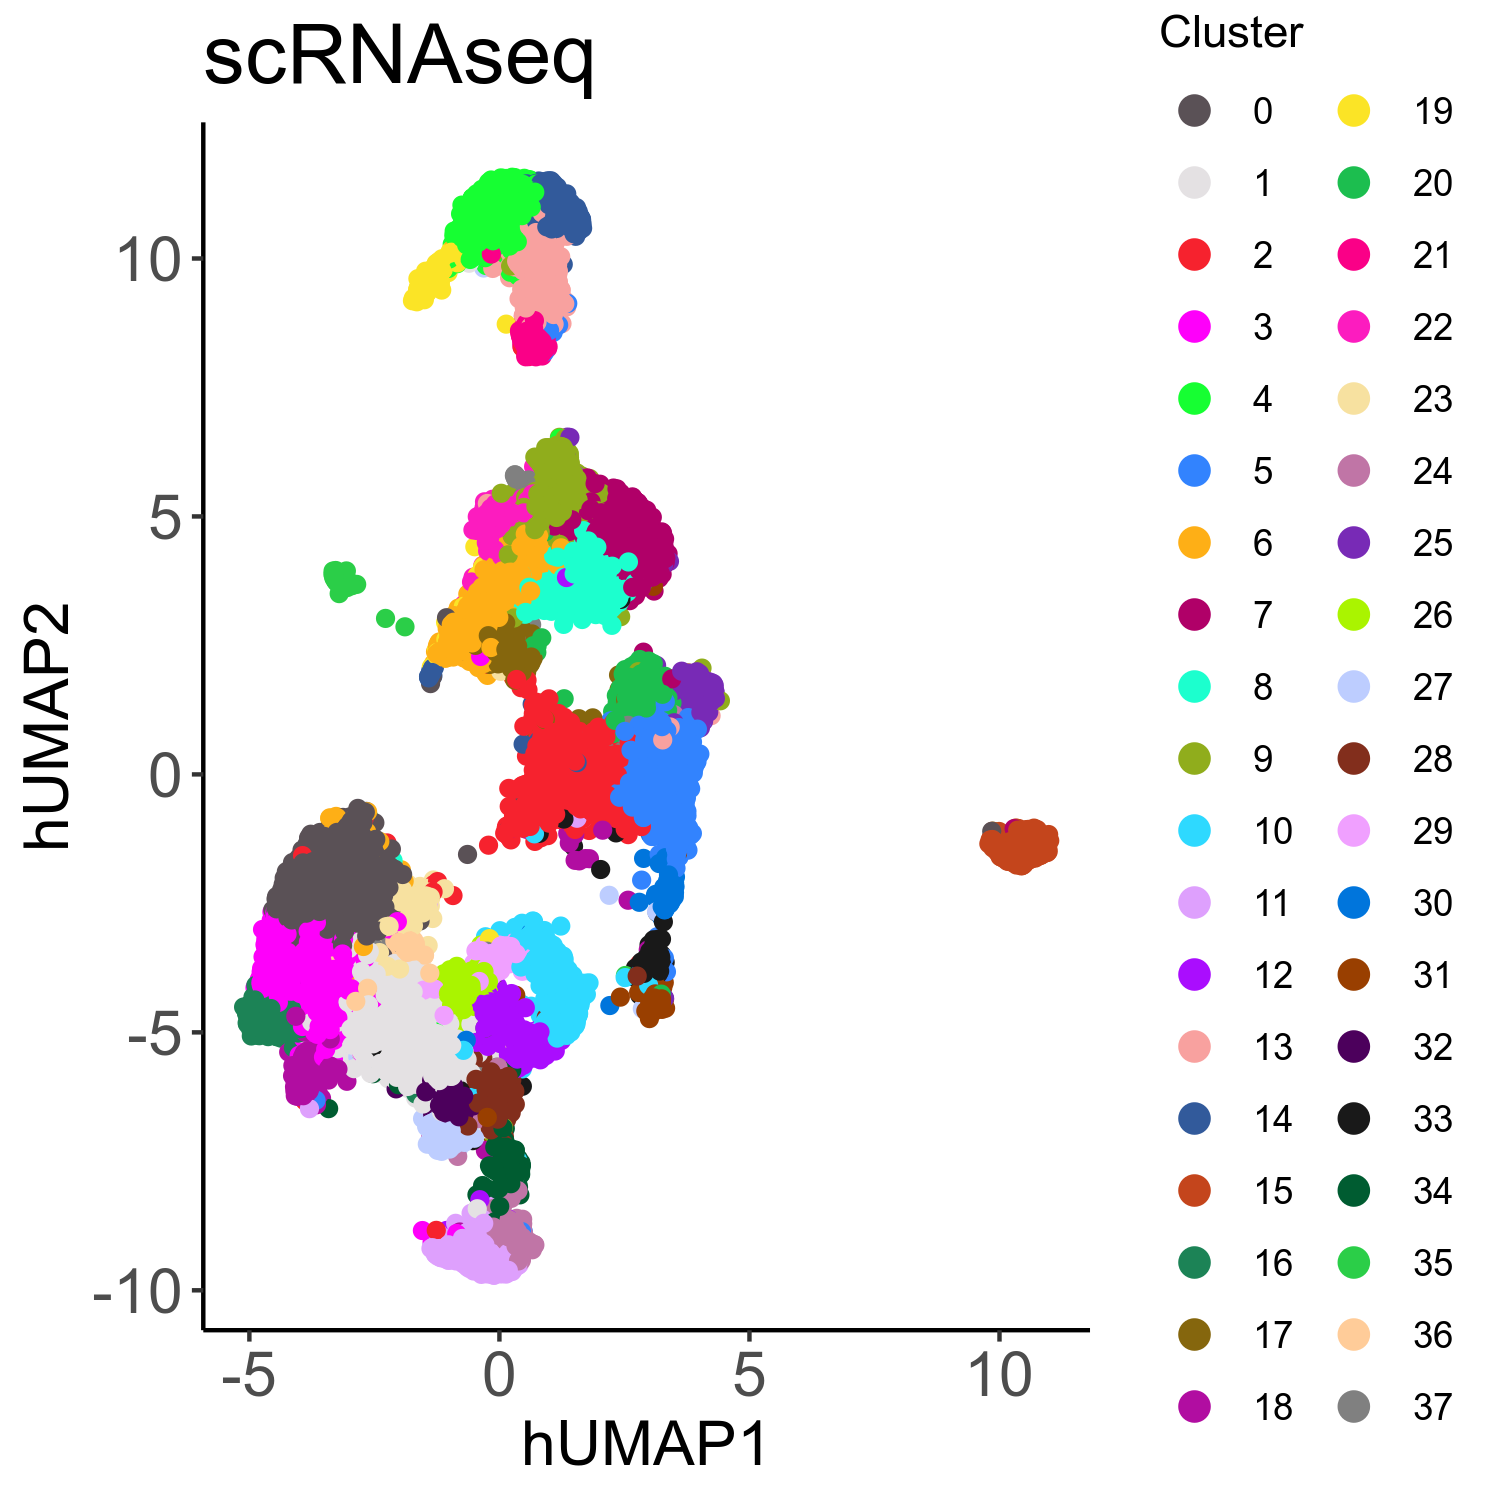

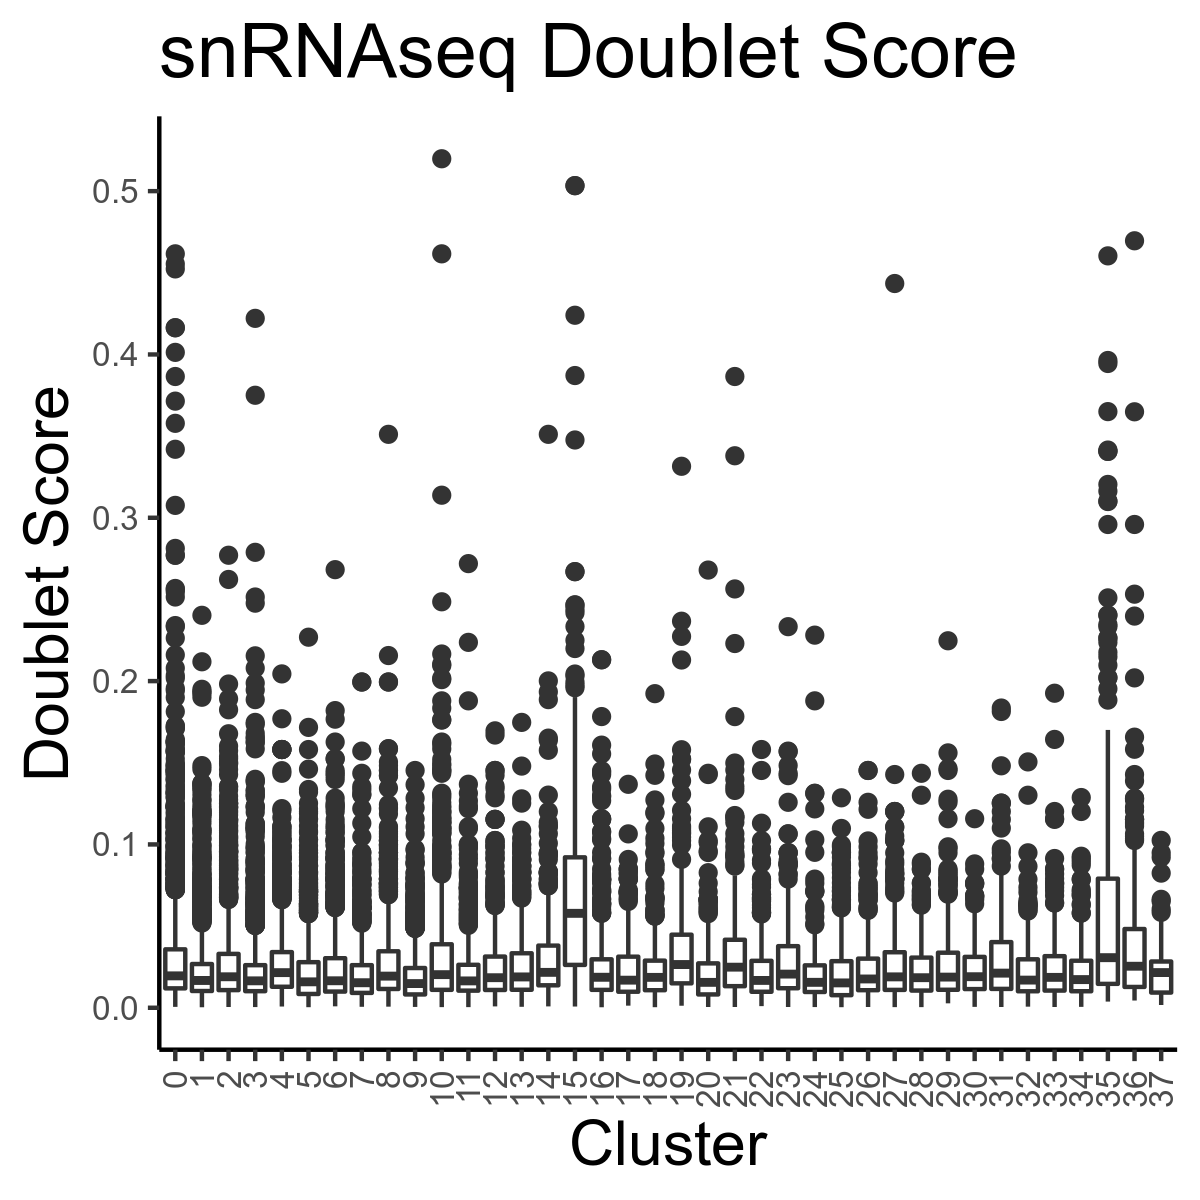

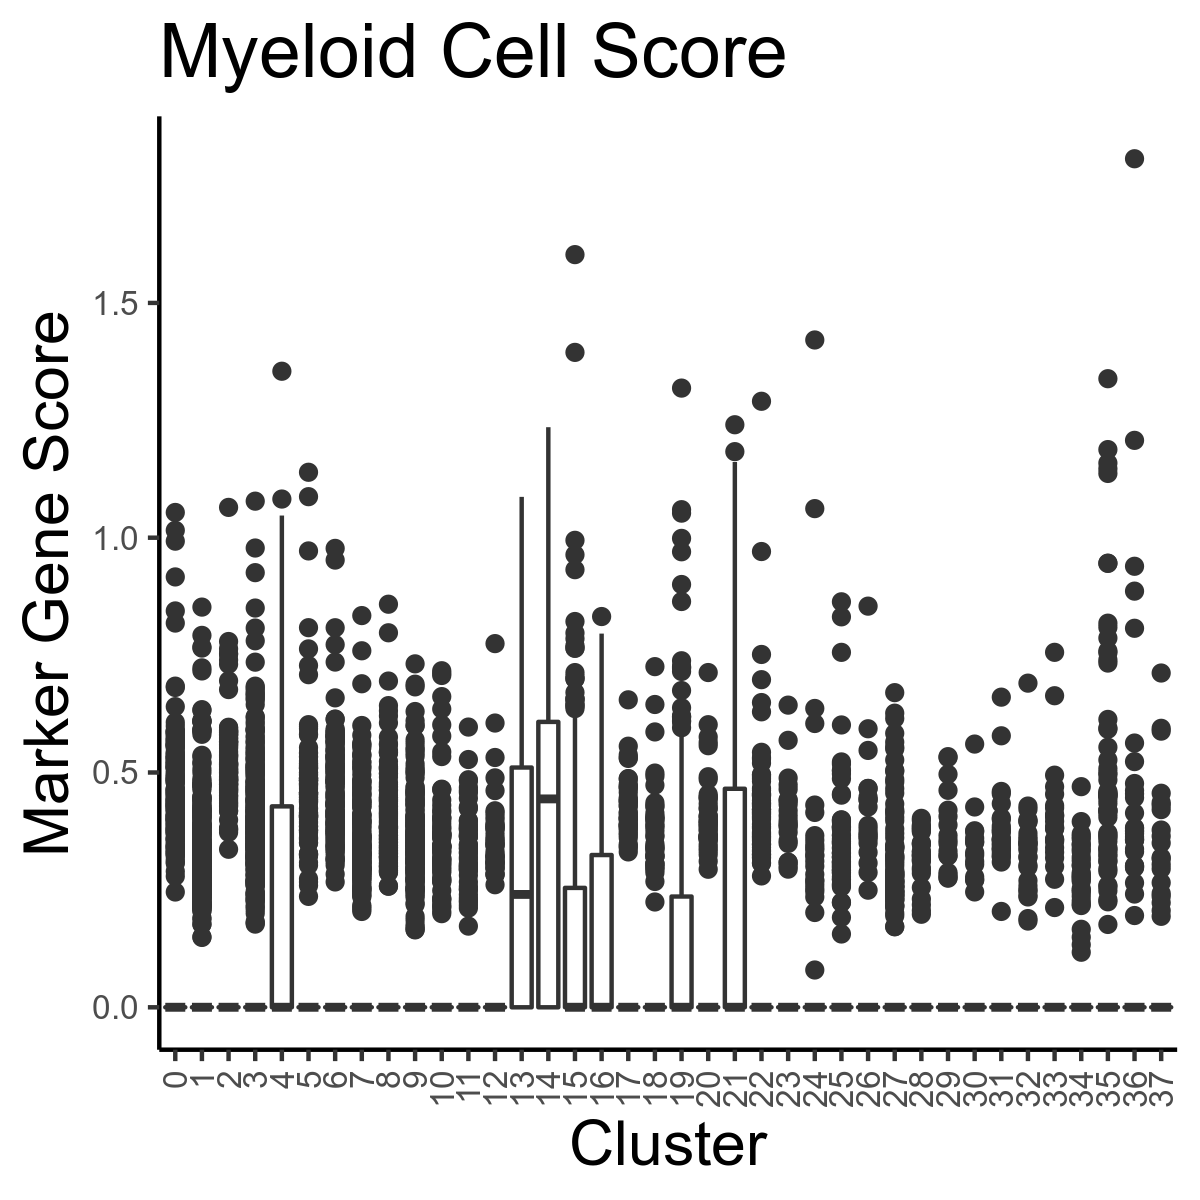

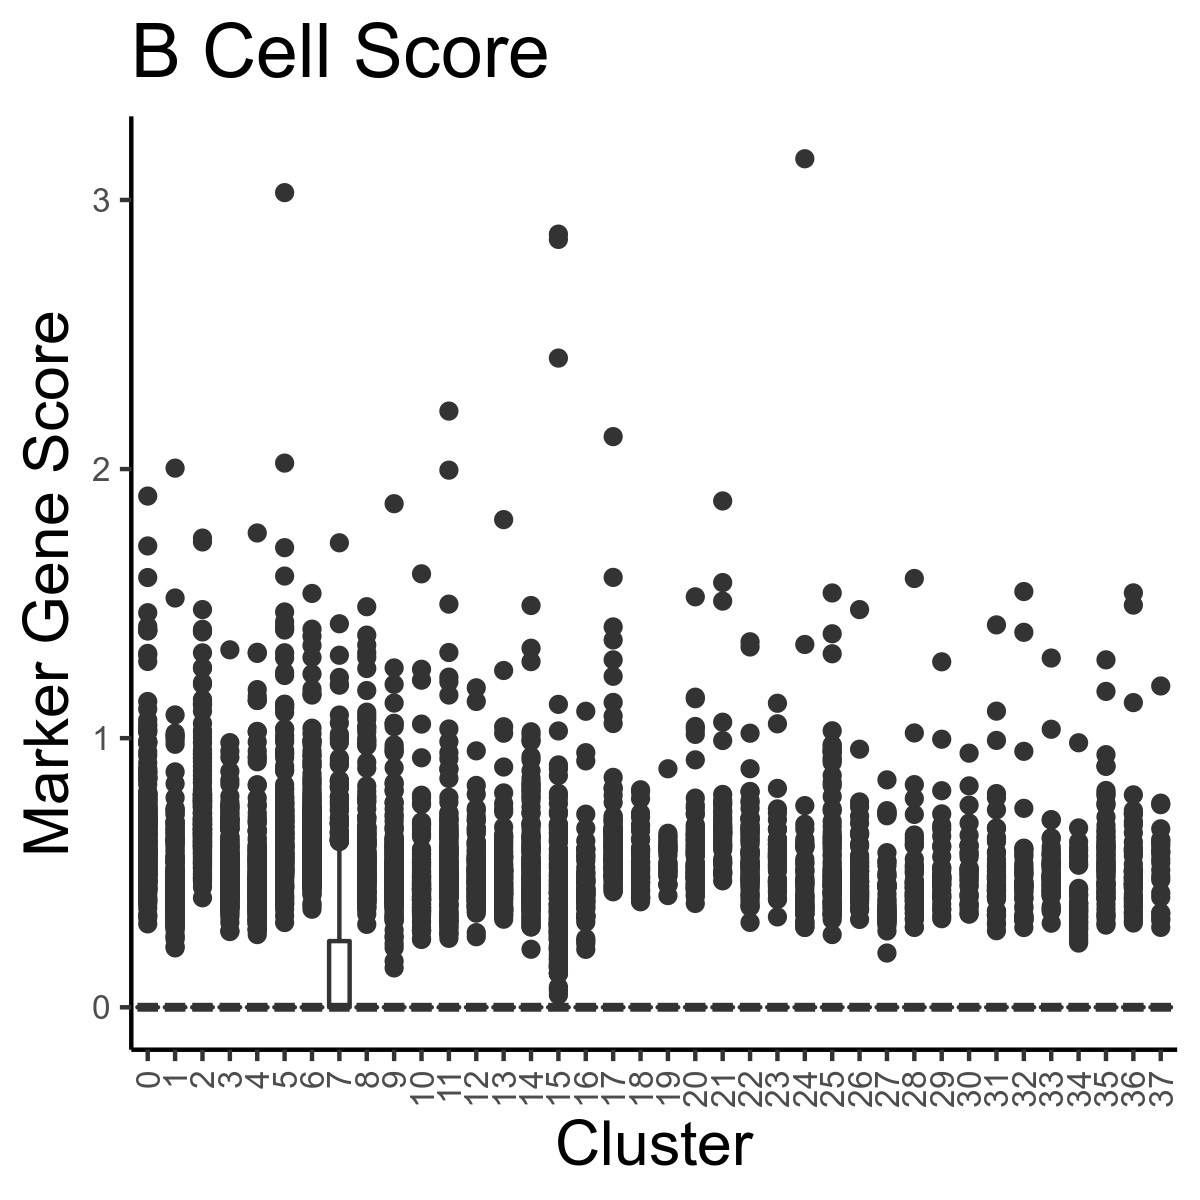

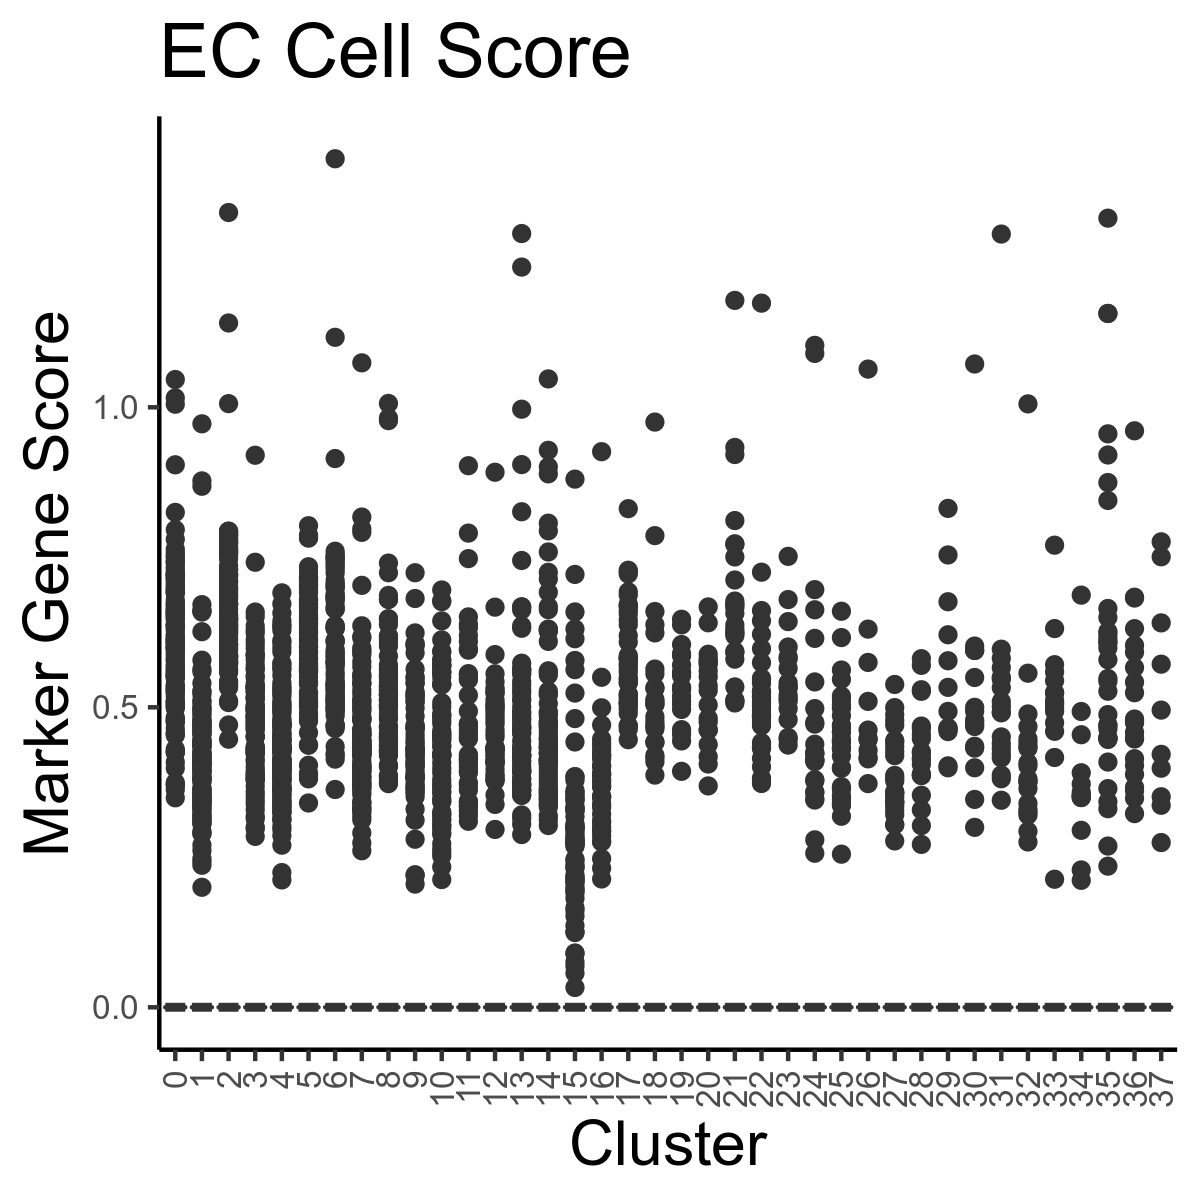

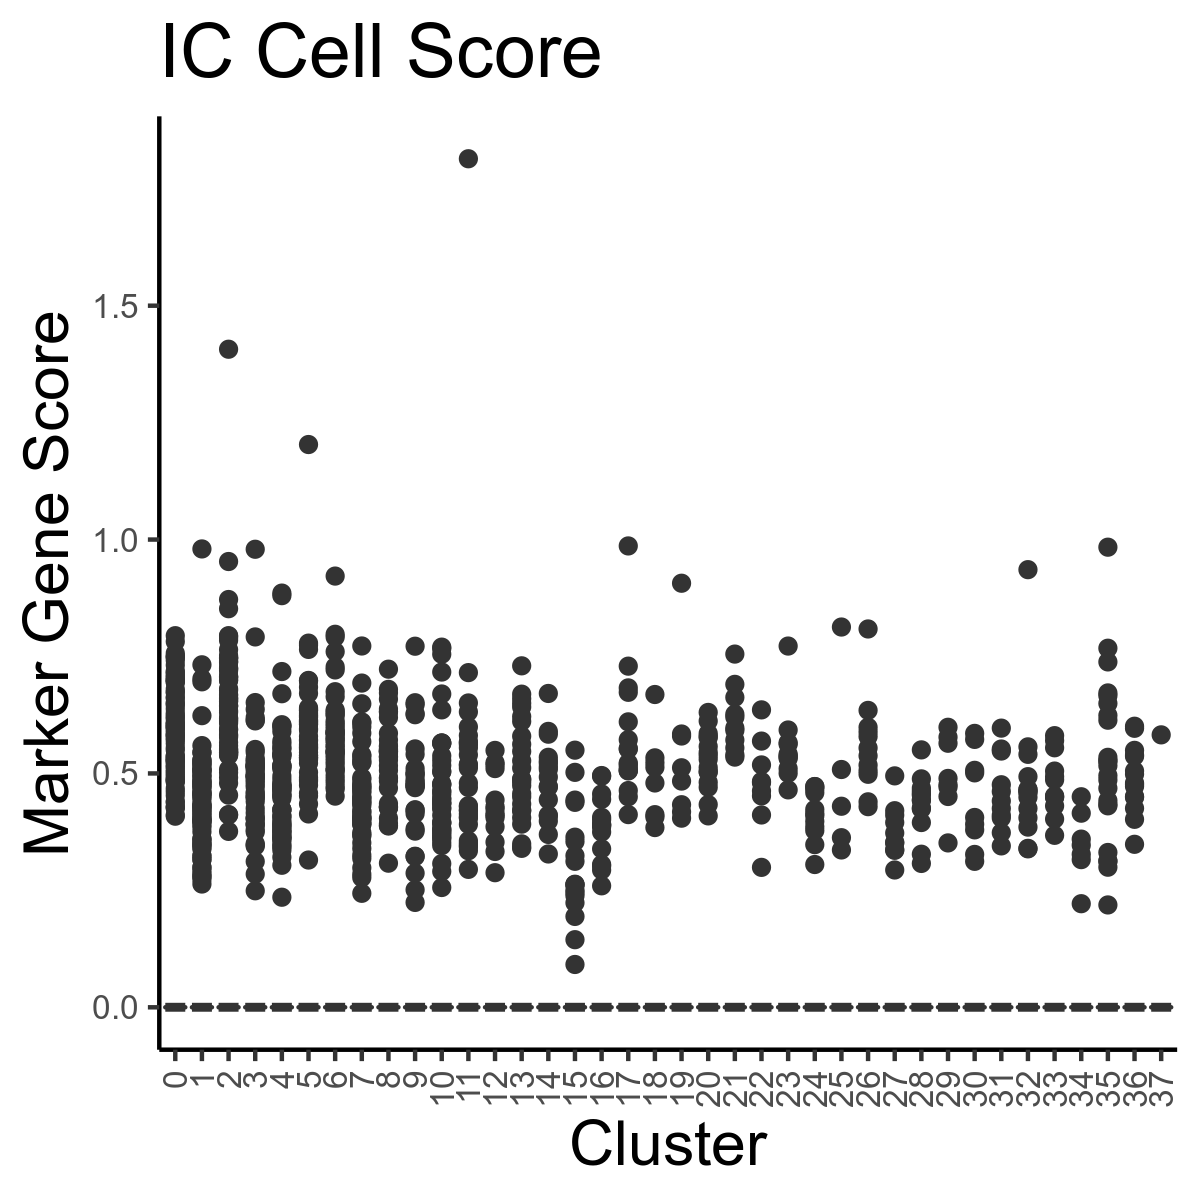

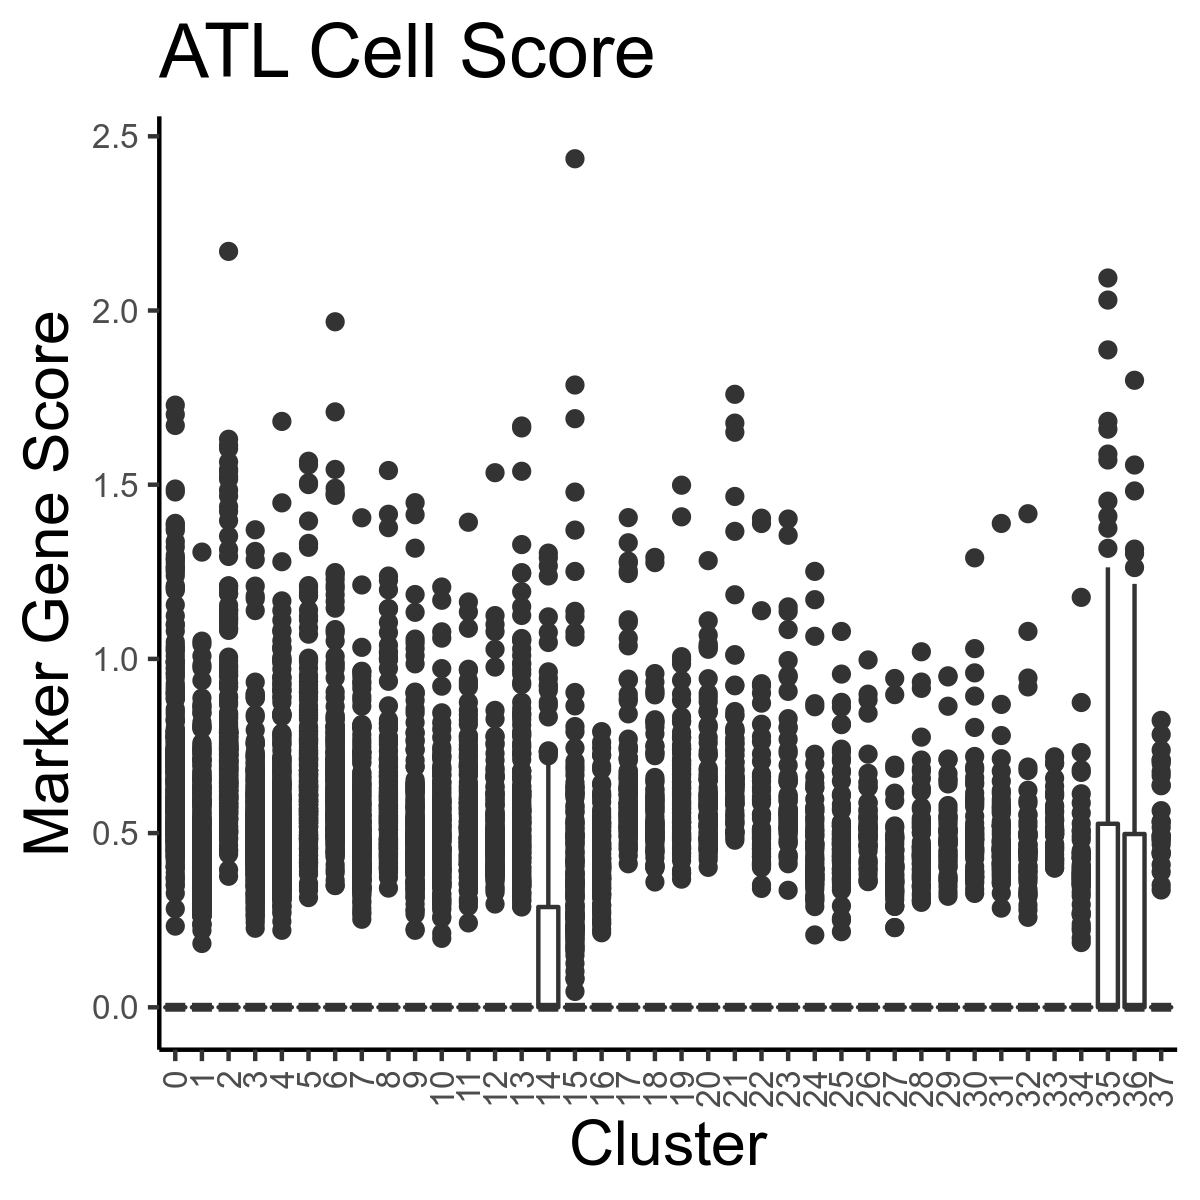

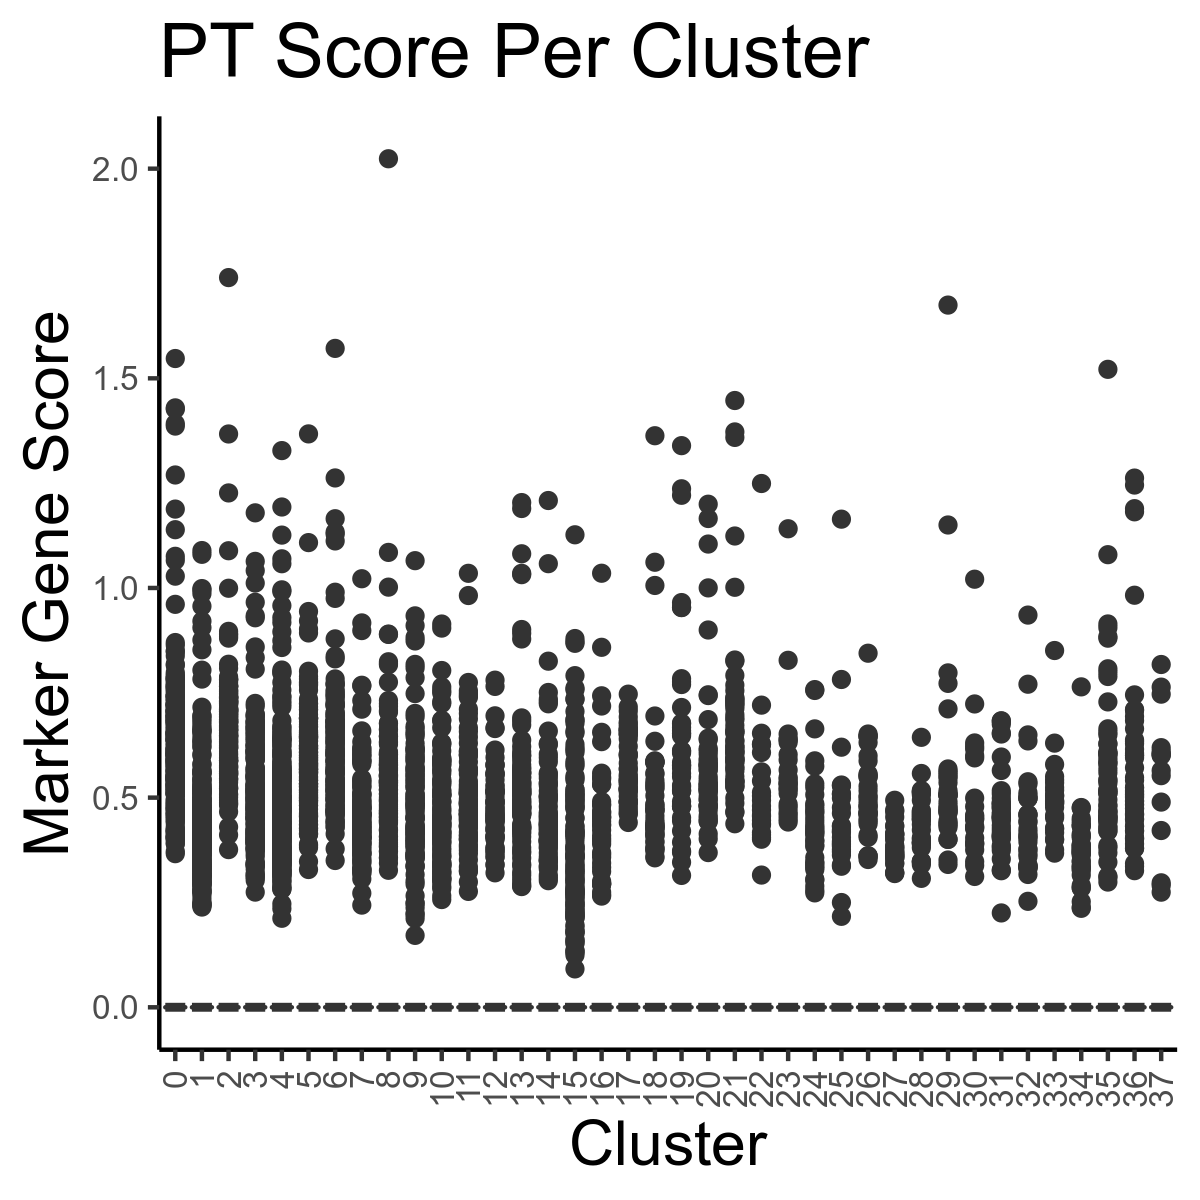

In [90]:
fig.size(5, 5)
ggplot(sc_meta %>% mutate(hUMAP1 = t_humap_res_sc[, 1], 
                           hUMAP2 = t_humap_res_sc[, 2]), 
                           aes(x = hUMAP1, y = hUMAP2, color = as.factor(qc_cluster))) + 
    geom_point() + 
    theme_classic() +
    scale_color_manual(values = c(as.vector(polychrome(29)), as.vector(alphabet(9))), drop = FALSE) +
    theme(axis.text = element_text(size = 15), axis.title = element_text(size = 15), plot.title = element_text(size = 20)) +
    labs(title = 'scRNAseq') +
    guides(colour = guide_legend(override.aes = list(size=3), title="Cluster"))



fig.size(4, 4)
ggplot(sc_meta, aes(x = as.character(qc_cluster), y = doublet_score)) + 
    geom_boxplot() + 
    theme_classic() +
    scale_x_discrete(limits = factor(seq(0, 37))) + 
    theme(axis.text = element_text(size = 8), axis.title = element_text(size = 15), plot.title = element_text(size = 18)) +
    labs(x = 'Cluster', y = 'Doublet Score', title = 'snRNAseq Doublet Score ') +
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))


ggplot(sc_meta, aes(x = as.character(qc_cluster), y = Myeloid)) + 
    geom_boxplot() + 
    theme_classic() +
    scale_x_discrete(limits = factor(seq(0, 37))) + 
    theme(axis.text = element_text(size = 8), axis.title = element_text(size = 15), plot.title = element_text(size = 18)) +
    labs(x = 'Cluster', y = 'Marker Gene Score', title = 'Myeloid Cell Score') +
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))

ggplot(sc_meta, aes(x = as.character(qc_cluster), y = B)) + 
    geom_boxplot() + 
    theme_classic() +
    scale_x_discrete(limits = factor(seq(0, 37))) + 
    theme(axis.text = element_text(size = 8), axis.title = element_text(size = 15), plot.title = element_text(size = 18)) +
    labs(x = 'Cluster', y = 'Marker Gene Score', title = 'B Cell Score') + 
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))



ggplot(sc_meta, aes(x = as.character(qc_cluster), y = EC)) + 
    geom_boxplot() + 
    theme_classic() +
    scale_x_discrete(limits = factor(seq(0, 37))) + 
    theme(axis.text = element_text(size = 8), axis.title = element_text(size = 15), plot.title = element_text(size = 18)) +
    labs(x = 'Cluster', y = 'Marker Gene Score', title = 'EC Cell Score') +
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))

ggplot(sc_meta, aes(x = as.character(qc_cluster), y = IC)) + 
    geom_boxplot() + 
    theme_classic() +
    scale_x_discrete(limits = factor(seq(0, 37))) + 
    theme(axis.text = element_text(size = 8), axis.title = element_text(size = 15), plot.title = element_text(size = 18)) +
    labs(x = 'Cluster', y = 'Marker Gene Score', title = 'IC Cell Score') +
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))

ggplot(sc_meta, aes(x = as.character(qc_cluster), y = ATL)) + 
    geom_boxplot() + 
    theme_classic() +
    scale_x_discrete(limits = factor(seq(0, 37))) + 
    theme(axis.text = element_text(size = 8), axis.title = element_text(size = 15), plot.title = element_text(size = 18)) +
    labs(x = 'Cluster', y = 'Marker Gene Score', title = 'ATL Cell Score') +
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))

ggplot(sc_meta, aes(x = as.character(qc_cluster), y = PT)) + 
    geom_boxplot() + 
    theme_classic() +
    scale_x_discrete(limits = factor(seq(0, 37))) + 
    theme(axis.text = element_text(size = 8), axis.title = element_text(size = 15), plot.title = element_text(size = 18)) +
    labs(x = 'Cluster', y = 'Marker Gene Score', title = 'PT Score Per Cluster') +
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))

Warning message:
“Removed 22 rows containing non-finite values (stat_boxplot).”


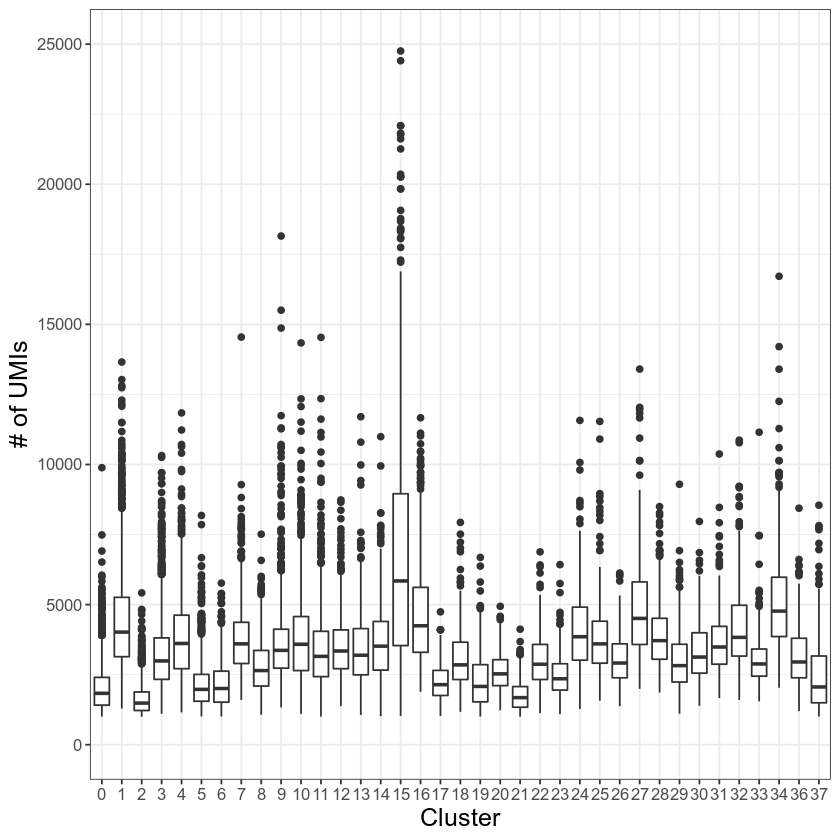

In [7]:
ggplot(qcd_meta %>% filter(dataset == 'scRNAseq'), aes(x = as.factor(qc_cluster), y = nCount_RNA)) + 
    geom_boxplot() + 
    theme_bw() + 
    labs(x = 'Cluster', y = '# of UMIs') + 
    theme(axis.title = element_text(size = 15), 
          axis.text = element_text(size = 10)) +
    scale_y_continuous(limits = c(0, 25000))

In [105]:
sc_meta <- sc_meta %>% filter(qc_cluster != 35)

In [109]:
qcd_meta <- rbind(sc_meta[, 1:17], nuc_meta[, 1:17])

In [112]:
qcd_norm <- t_norm[, qcd_meta %>% pull(cell)]

In [113]:
saveRDS(qcd_meta, '/data/srlab/ssg34/SLE_kidney_v2/data/qcd/T_refmapped_RA_qcd_meta_10252022.rds')
saveRDS(qcd_norm, '/data/srlab/ssg34/SLE_kidney_v2/data/qcd/T_refmapped_RA_qcd_norm_10252022.rds')

## Weighted PCA, Harmony

In [89]:
old_meta <- readRDS('/data/srlab/ssg34/SLE_kidney_v2/data/qcd/T_NK_clusterQCd_meta_harmonizedPCUMAPclusters_annotations09212022.rds')

In [2]:
qcd_meta <- readRDS('/data/srlab/ssg34/SLE_kidney_v2/data/qcd/T_refmapped_RA_qcd_meta_10252022.rds')
qcd_norm <- readRDS('/data/srlab/ssg34/SLE_kidney_v2/data/qcd/T_refmapped_RA_qcd_norm_10252022.rds')

In [3]:
# weighted PCA is in immunogenomics/singlecellmethods, function weighted_pca
weighted_pca <- function(X, weights, genes_use=NULL, npc=20, do_corr=TRUE, scale_thresh=10) {
    if (!identical(length(weights), ncol(X))) {
        stop('Columns in X must match length of weights')
    }
    
#     y <- factor(y)
#     weights <- as.numeric((1 / prop.table(table(y)))[y]) / nlevels(y)
    if (any(is.na(weights))) {
        idx_keep <- which(is.na(weights))
#         y <- y[idx_keep]
        weights <- weights[idx_keep]
        X <- X[, idx_keep]
    }
    if (is.null(genes_use)) {
        genes_use <- row.names(X)
    } else if (length(genes_use) < nrow(X)) {
        if (any(!genes_use %in% row.names(X))) {
            stop('genes_use not in rownames of X')
        }
        X <- X[genes_use, ]
    }
    
    ## weighted z-scores
#     mu <- X %>% apply(1, function(x) {SDMTools:::wt.mean(x, weights)})
#     sig <- X %>% apply(1, function(x) {SDMTools:::wt.sd(x, weights)})
    mu <- singlecellmethods::rowMeans(X, weights = weights)
    sig <- singlecellmethods::rowSDs(X, weights = weights)
    
    # Added 12/9/19: save weighted scaling means and std devs
    vargenes_means_sds <- tibble(
        symbol = genes_use,
        mean = mu
    )
    vargenes_means_sds$stddev <- sig
    # finish added 12/9/19
    
    X <- scaleDataWithStats(X, mu, sig) 
    X <- X[which(is.na(rowSums(X)) == 0), ]
    if (do_corr) {
        X <- X %>% scale() %>% pmin(scale_thresh) %>% pmax(-scale_thresh)
    }
    
    ## weighted SVD
#     pres <- rsvd::rsvd(X %*% Matrix::Diagonal(x = sqrt(weights)), k = npc)
    pres <- RSpectra::svds(X %*% Matrix::Diagonal(x = sqrt(weights)), npc)
    V <- (Matrix::Diagonal(x = 1 / sqrt(weights)) %*% pres$v) %*% diag(pres$d)
    V <- as.matrix(V)
    colnames(V) <- paste0('PC', 1:npc)
    row.names(V) <- colnames(X)
    colnames(pres$u) <- paste0('PC', 1:npc)
    row.names(pres$u) <- row.names(X)
    return(list(loadings = pres$u, embeddings = V, vargenes = vargenes_means_sds))
}

# Cosine normalize values
cosine_normalize <- function(X, MARGIN = 1, do_safe = TRUE) {
    if (do_safe) {
        X <- sweep(X, MARGIN, apply(X, MARGIN, max), "/")
    }
    sweep(X, MARGIN, apply(X, MARGIN, function(x) sqrt(sum(x^2))), "/")
}
                           
                                                    
do_pca <- function(X, weights, genes_use=NULL, npc=10, do_corr=TRUE) {
    if (is.null(genes_use)) {
        genes_use <- row.names(X)
    }
    mu <- X[genes_use, ] %>% apply(1, function(x) {SDMTools:::wt.mean(x, weights)})
    sig <- X[genes_use, ] %>% apply(1, function(x) {SDMTools:::wt.sd(x, weights)})
    
    X <- X[genes_use, ] %>% scaleDataWithStats(mu, sig) 
    X <- X[which(is.na(rowSums(X)) == 0), ]
    if (do_corr) {
        X <- scale(X)
    }
    pres <- rsvd::rsvd(X, k = npc)
    V <- pres$v %*% diag(pres$d)
    V <- data.table(V)
    colnames(V) <- paste0('PC', 1:npc)
    return(V)    
}
                           
get_stats <- function(X, weights, genes_use=NULL) {
    if (is.null(genes_use)) {
        genes_use <- row.names(X)
    }
    mu <- X[genes_use, ] %>% apply(1, function(x) {SDMTools:::wt.mean(x, weights)})
    sig <- X[genes_use, ] %>% apply(1, function(x) {SDMTools:::wt.sd(x, weights)})
    return(list(mu = mu, sig = sig))
}
                           
                           
plot_shuffled_features <- function(ab, umap, exprs, pct) {
    library(viridis)
    max.cutoff = quantile(exprs[ab,], pct)
    min.cutoff = quantile(exprs[ab,], 1-pct)
    
    tmp <- sapply(X = exprs[ab,], FUN = function(x) {
        return(ifelse(test = x > max.cutoff, yes = max.cutoff,
            no = x))
    })
    tmp <- sapply(X = tmp, FUN = function(x) {
        return(ifelse(test = x < min.cutoff, yes = min.cutoff,
            no = x))
    })
    umap_res_plot <- cbind(umap, tmp)
    return(ggplot(data = as.data.frame(umap_res_plot)[sample(nrow(umap_res_plot)),] , aes(x = V1, y = V2)) +
      geom_point(mapping = aes(color = tmp), size = 0.75) +
      scale_color_viridis(option = "inferno", end = pct) +
      theme_classic() +
      theme(plot.title = element_text(size = 15), legend.position = "none") +
      labs(title = ab, x = 'hUMAP1', y = 'hUMAP2', color = "Normalized Expression"))
}
                           fig.size <- function (height, width) {
    options(repr.plot.height = height, repr.plot.width = width, repr.plot.res = 300)
}
                           
                           
vargenes_vst <- function(object, groups, topn, loess.span = 0.3) {
    clip.max <- sqrt(ncol(object))

    N <- ncol(object)
    if (missing(groups)) {
        groups <- rep('A', N)
    }
    
    res <- split(seq_len(N), groups) %>% lapply(function(idx) {
        object_group <- object[, idx]
        ## row means
        hvf.info <- data.frame(
          symbol = rownames(object_group), 
          mean = Matrix::rowMeans(object_group)
        )

        ## row vars
        hvf.info$variance <- rowVars(object_group, hvf.info$mean)

        ## initialize
        hvf.info$variance.expected <- 0
        hvf.info$variance.standardized <- 0

        not.const <- hvf.info$variance > 0

        ## loess curve fit 
        suppressWarnings({
            fit <- loess(formula = log10(variance) ~ log10(mean), 
                data = hvf.info[not.const, ], span = loess.span)            
        })

        ## extract fitted variance 
        hvf.info$variance.expected[not.const] <- 10^fit$fitted

        ## get row standard deviations after clipping
        hvf.info$variance.standardized <- rowVarsStd(
            object_group, 
            hvf.info$mean, 
            sqrt(hvf.info$variance.expected), 
            clip.max
        )

        hvf.info <- hvf.info %>% 
#             tibble::rownames_to_column('symbol') %>% 
            arrange(-variance.standardized) %>% 
            tibble::rowid_to_column('rank') %>% 
            transform(group = unique(groups[idx]))

        return(hvf.info)        
    })
    
    
    if (missing(topn)) {
        ## MODE 1: return table 
        res <- Reduce(rbind, res) %>% 
            dplyr::select(group, symbol, rank, everything())

        if (length(unique(res$group)) == 1) {
            res$group <- NULL
        }
    } else {
        ## MODE 2: return genes
        res <- lapply(res, function(x) head(x, topn)$symbol)
    }
    return(res)
}

In [4]:
## Filtering for expressed genes
threshold_genes <- qcd_norm[rownames(qcd_norm[rowMeans(qcd_norm) >= .01, ]), ]

samples_25 <- qcd_meta %>% group_by(sample) %>% tally() %>% filter(n > 25) %>% pull(sample)

threshold_samples <- threshold_genes[, qcd_meta %>% filter(sample %in% samples_25) %>% pull(cell)]

## Variable gene selection — very inefficiently written, but essentially using VST to select most variable genes from samples with > 100 cells
var_genes_raw <- vargenes_vst(object = threshold_samples, groups = qcd_meta %>% filter(sample %in% samples_25) %>% pull(sample), topn = 500)

In [5]:
#Separate variable genes by Dataset
var_genes_raw_nuc <- vector()
var_genes_raw_sc <- vector()

for (i in 1:length(var_genes_raw)) {
    if (grepl('nuc', names(var_genes_raw)[i])) {
        var_genes_raw_nuc <- c(var_genes_raw_nuc, var_genes_raw[[i]])
    }
    else {
        var_genes_raw_sc <- c(var_genes_raw_sc, var_genes_raw[[i]])   
    }

}

var_genes_raw_nuc <- var_genes_raw_nuc %>% unique()
var_genes_raw_sc <- var_genes_raw_sc %>% unique() 
#Find intersection
var_genes <- intersect(var_genes_raw_nuc, var_genes_raw_sc)

In [9]:
## Scale Data
t_scaled <- qcd_norm[var_genes[!var_genes %in% genes_exclude], ] %>% scaleData()

In [10]:
table(qcd_meta$dataset)
y <- factor(qcd_meta$dataset)
weights <- as.numeric((1 / prop.table(table(y)))[y]) / nlevels(y)
length(weights)
table(weights)


scRNAseq snRNAseq 
   30919     2239 

[1] 33158

weights
0.536207509945341  7.40464493077267 
            30919              2239 

In [12]:
t_scaled <- as(t_scaled, 'dgCMatrix')

In [13]:
weighted_pca_res <- weighted_pca(t_scaled, weights, rownames(t_scaled), 20, TRUE, 10)$embeddings

use_weights



[1] TRUE


use_weights

use_weights



[1] TRUE


use_weights

Harmony 1/20

Harmony 2/20

Harmony 3/20

Harmony 4/20

Harmony 5/20

Harmony 6/20

Harmony 7/20

Harmony 8/20

Harmony 9/20

Harmony 10/20

Harmony 11/20

Harmony 12/20

Harmony 13/20

Harmony 14/20

Harmony 15/20

Harmony 16/20

Harmony 17/20

Harmony 18/20

Harmony 19/20

Harmony 20/20



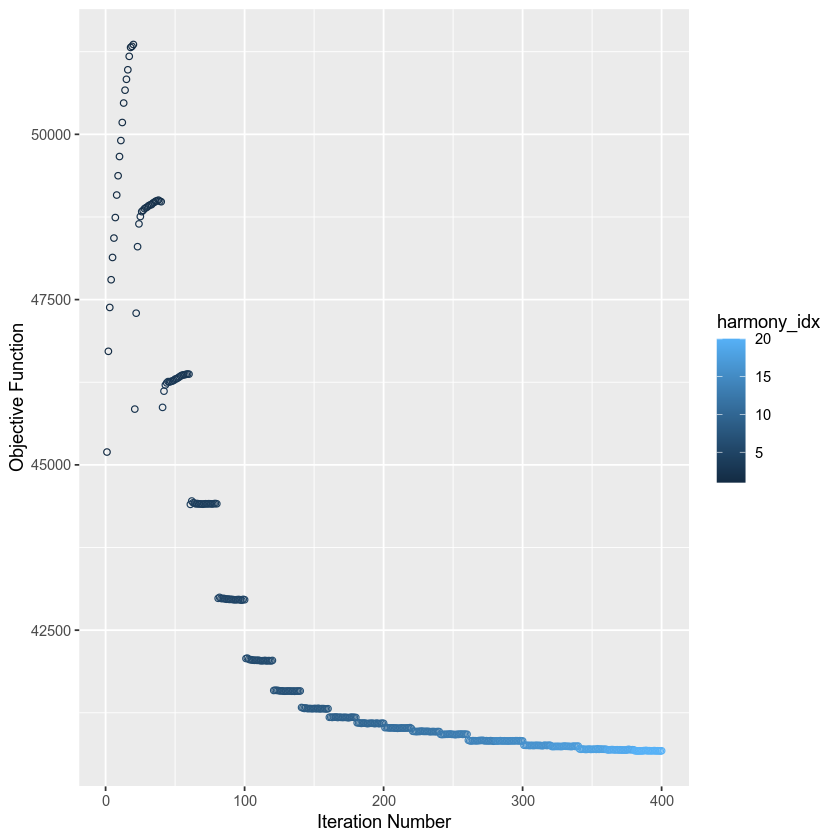

In [14]:
harmony_weighted2 <- HarmonyMatrix(weighted_pca_res, qcd_meta, 
                            c('sample', 'processing.batch', 
                              'Site', 'dataset'), 
                            do_pca = FALSE, 
                            epsilon.harmony = -Inf, 
                            epsilon.cluster = -Inf,
                            weights = weights, 
                            max.iter.cluster = 20,
                            max.iter.harmony = 20, 
                            plot_convergence = TRUE, 
                            verbose = TRUE)

In [23]:
harmony_umap2 <- uwot::umap(harmony_weighted2, n_neighbors = 30L, min_dist = 0.1, metric = 'euclidean')
weighted_umap <- uwot::umap(weighted_pca_res, n_neighbors = 30L, min_dist = 0.1, metric = 'euclidean')

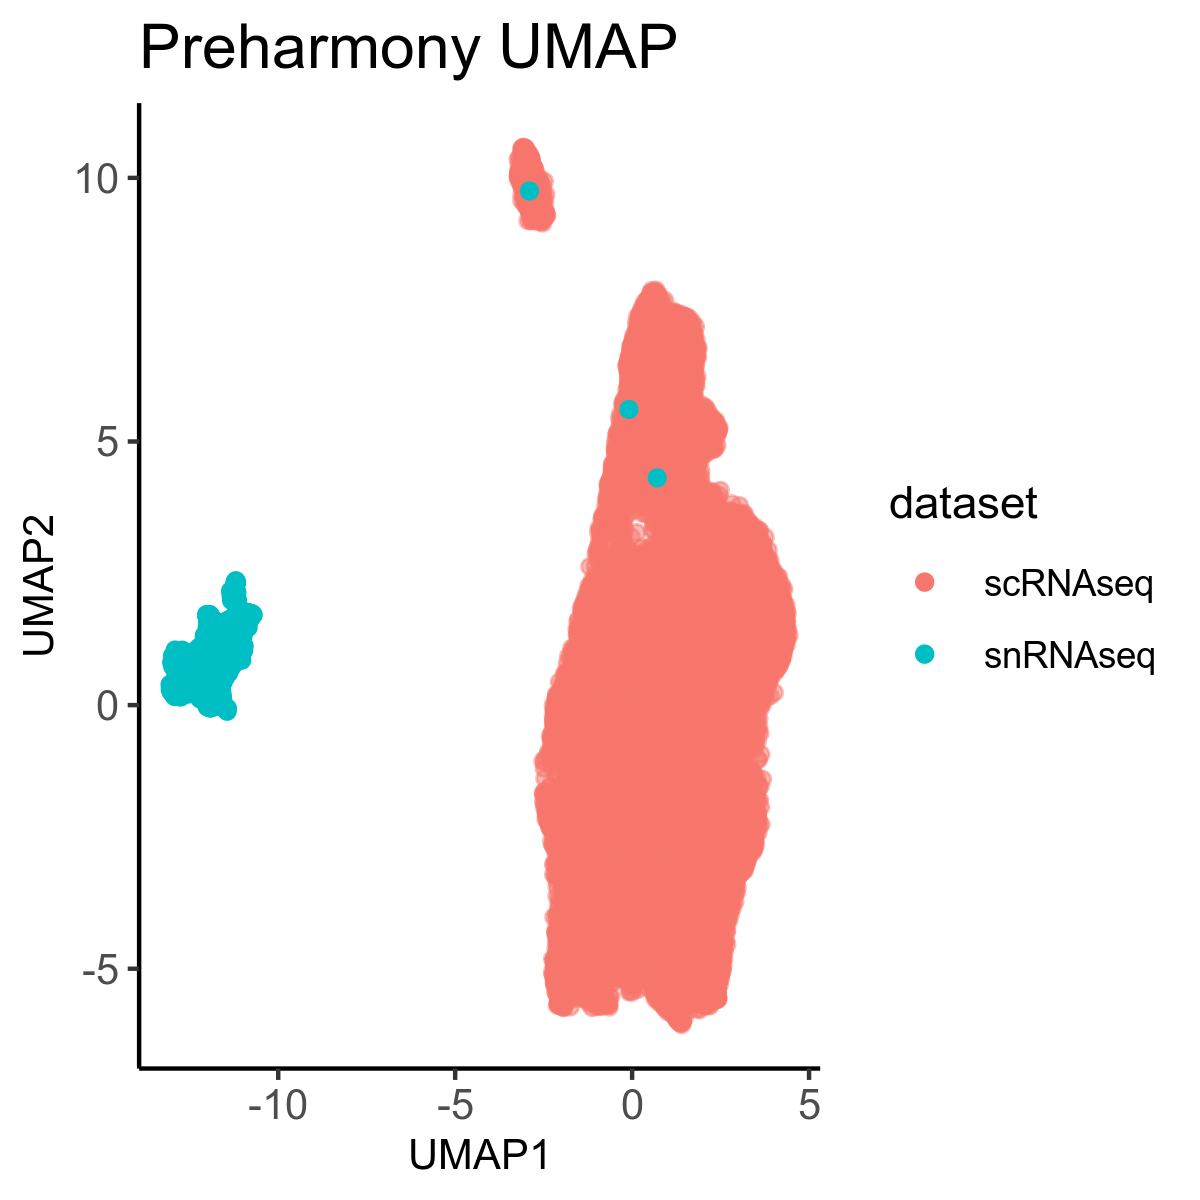

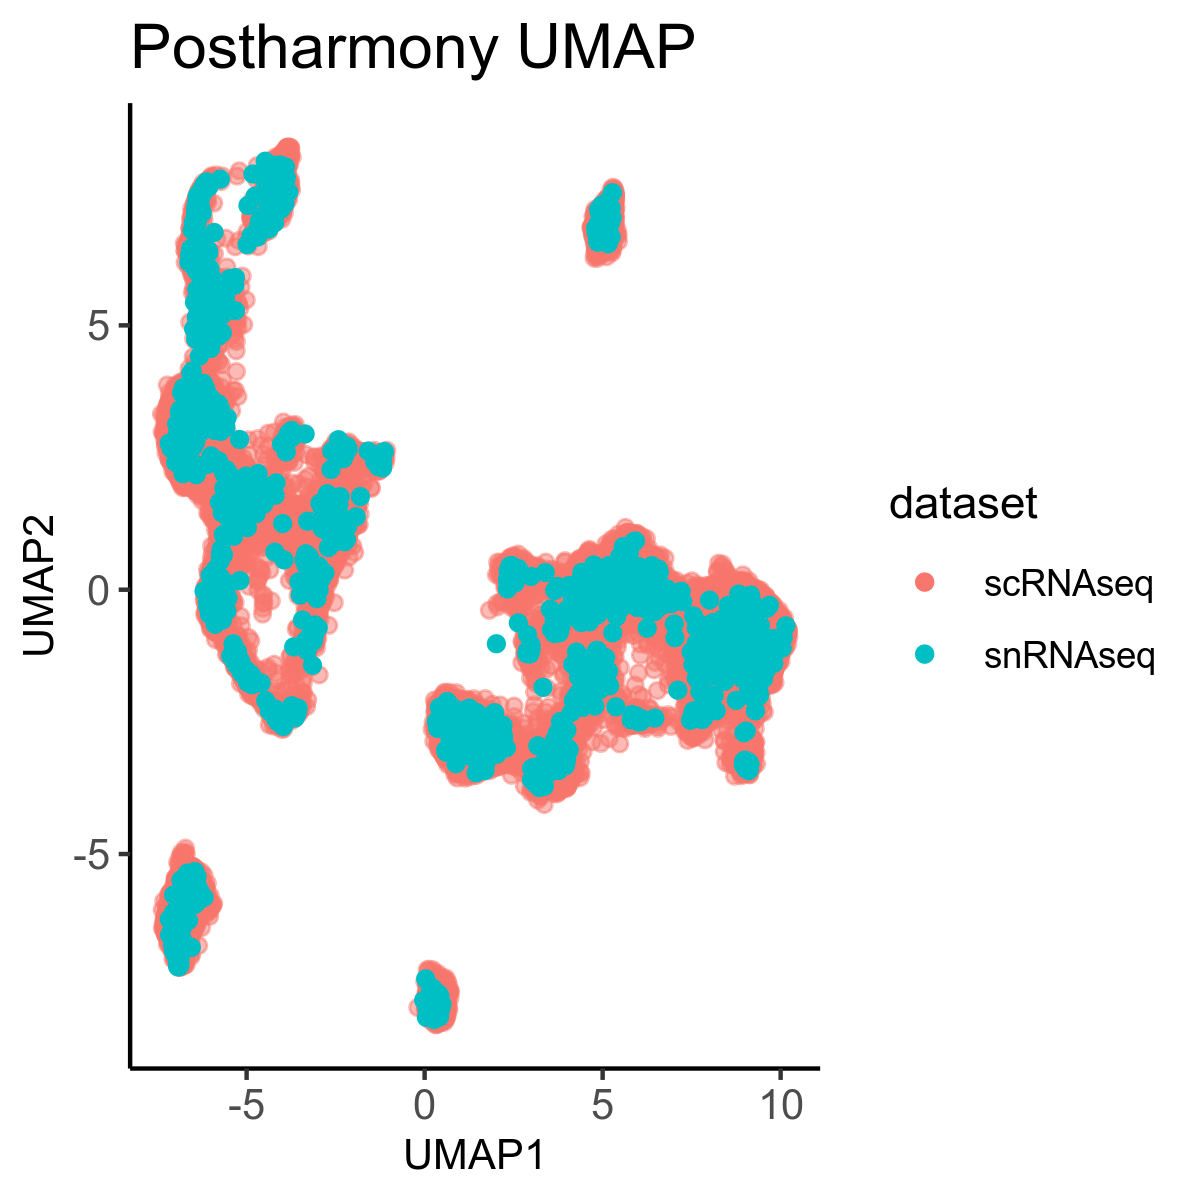

In [24]:
fig.size(4, 4)

df <- weighted_umap %>% data.frame() %>% mutate(dataset = qcd_meta$dataset)
df <- df[sample(nrow(df)), ]
ggplot(df, aes(x = X1, y = X2, color = dataset)) +
    geom_point(data = df %>% filter(dataset == 'scRNAseq'), alpha = 0.5, size = 1.5) +
    geom_point(data = df %>% filter(dataset == 'snRNAseq'), alpha = 2, size = 1.5) +
    theme_classic() + 
    theme(axis.text = element_text(size = 10), axis.title = element_text(size = 10), plot.title = element_text(size = 15)) +
    labs(title = 'Preharmony UMAP', x = 'UMAP1', y = 'UMAP2')

df <- harmony_umap2 %>% data.frame() %>% mutate(dataset = qcd_meta$dataset)
df <- df[sample(nrow(df)), ]
fig.size(4, 4)
ggplot(df, aes(x = X1, y = X2, color = dataset)) +
    geom_point(data = df %>% filter(dataset == 'scRNAseq'), alpha = 0.5, size = 1.5) +
    geom_point(data = df %>% filter(dataset == 'snRNAseq'), alpha = 2, size = 1.5) +
    theme_classic() + 
    theme(axis.text = element_text(size = 10), axis.title = element_text(size = 10), plot.title = element_text(size = 15)) +
    labs(title = 'Postharmony UMAP', x = 'UMAP1', y = 'UMAP2')

In [25]:
snn_ref <- BuildSNNSeurat(harmony_weighted2[,1:20], nn.eps = 0)


resolution_list <- c(0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0)
ids_ref <- Reduce(cbind, mclapply(resolution_list, function(res_use) {
    Seurat:::RunModularityClustering(SNN = snn_ref, modularity = 1,
        resolution = res_use, algorithm = 1, n.start = 20,
        n.iter = 20, random.seed = 100, print.output = FALSE,
        temp.file.location = NULL, edge.file.name = NULL)
}, mc.preschedule = FALSE, mc.cores = min(20, length(resolution_list)))) 

In [27]:
harmony_umap2 <- cbind(harmony_weighted2[, 1:20], harmony_umap2, ids_ref)
colnames(harmony_umap2) <- c(paste0('hPC', 1:20), 'hUMAP1', 'hUMAP2', 'hres0.2', 'hres0.4', 'hres0.6', 'hres0.8', 'hres1.0', 'hres1.2', 'hres1.4', 'hres1.6', 'hres1.8', 'hres2.0')

In [30]:
qcd_meta <- cbind(qcd_meta %>% 
                  select(-c(UMAP1, UMAP2)),
                                                harmony_umap2) 

In [32]:
saveRDS(qcd_meta, '/data/srlab/ssg34/SLE_kidney_v2/data/qcd/T_refmapped_RA_qcd_harmonizedPCUMAP_clustered_meta_10252022.rds')

## Cell State Clustering

In [3]:
pivot_wilcox_expr <- function(wilcox_obj) {
    df <- wilcox_obj %>% select(group, feature, avgExpr) %>% 
                    pivot_wider(names_from = 'feature', values_from = 'avgExpr') %>% data.frame()
    rownames(df) <- df$group
    df <- df %>% select(-group) %>% as.matrix()
    return(df)
}

pivot_wilcox_logFC <- function(wilcox_obj) {
    df <- wilcox_obj %>% select(group, feature, logFC) %>% 
                    pivot_wider(names_from = 'feature', values_from = 'logFC') %>% data.frame()
    rownames(df) <- df$group
    df <- df %>% select(-group) %>% as.matrix()
    return(df)
}

In [3]:
qcd_meta <- readRDS('/data/srlab/ssg34/SLE_kidney_v2/data/qcd/T_refmapped_RA_qcd_harmonizedPCUMAP_clustered_meta_10252022.rds')
qcd_norm <- readRDS('/data/srlab/ssg34/SLE_kidney_v2/data/qcd/T_refmapped_RA_qcd_norm_10252022.rds')

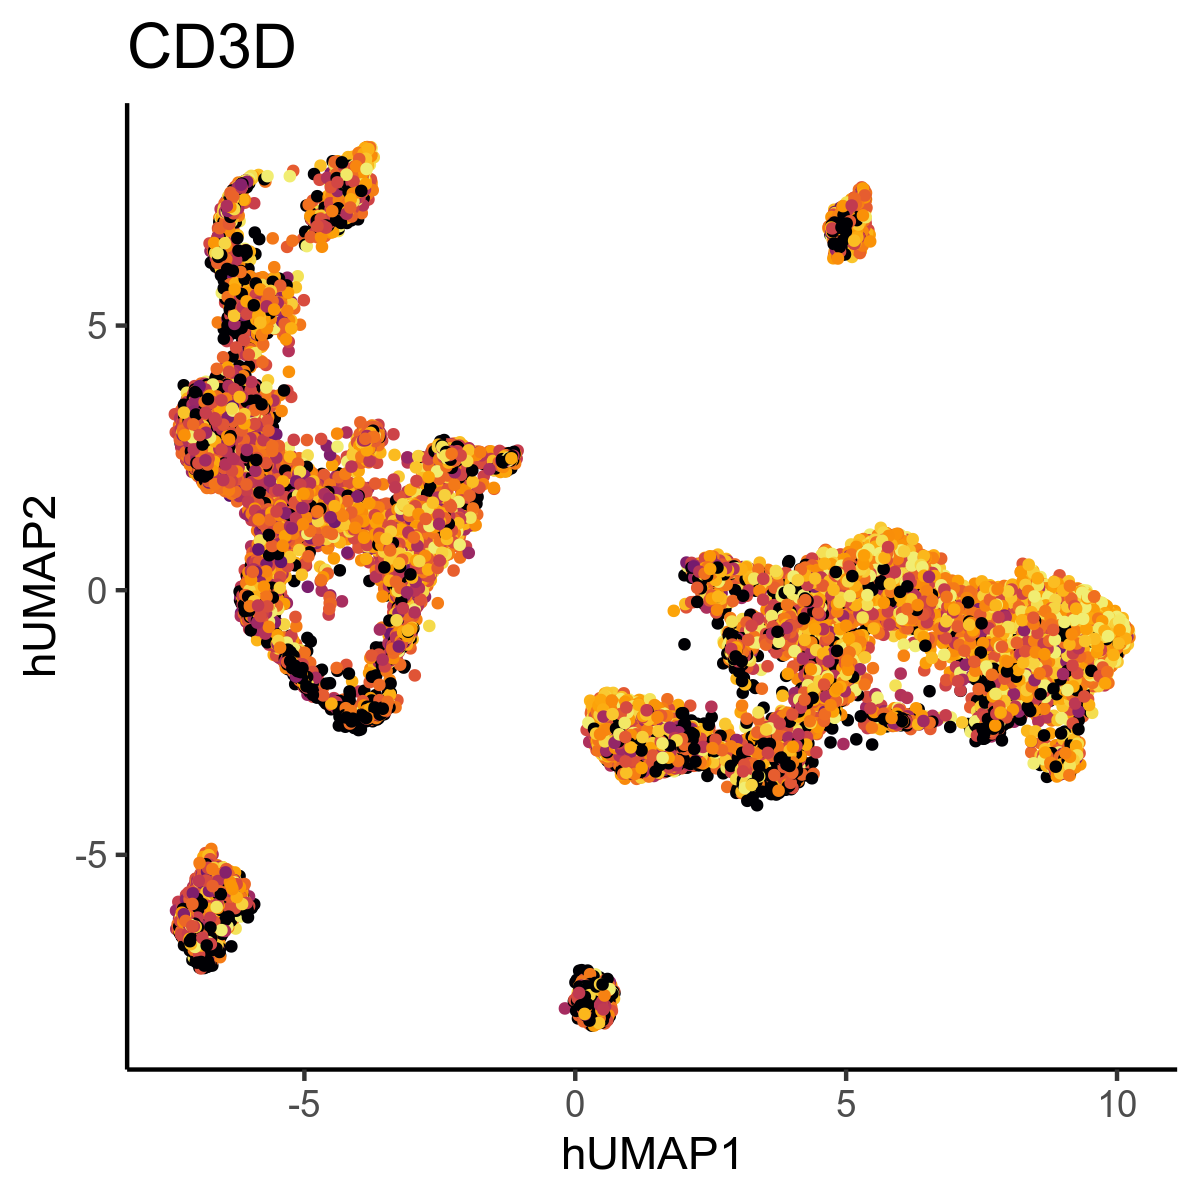

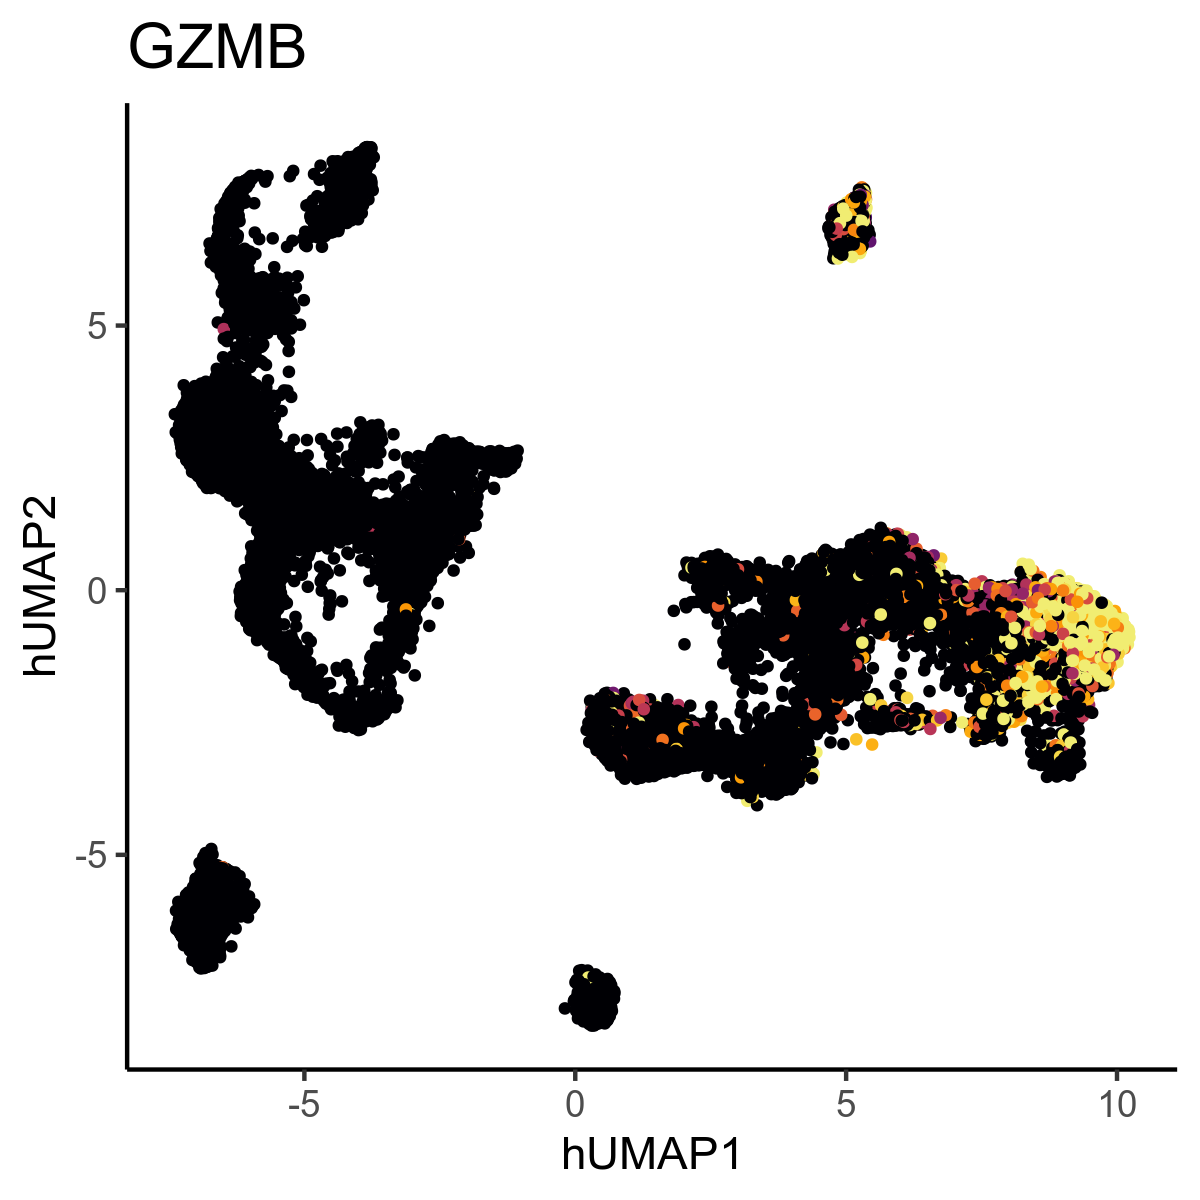

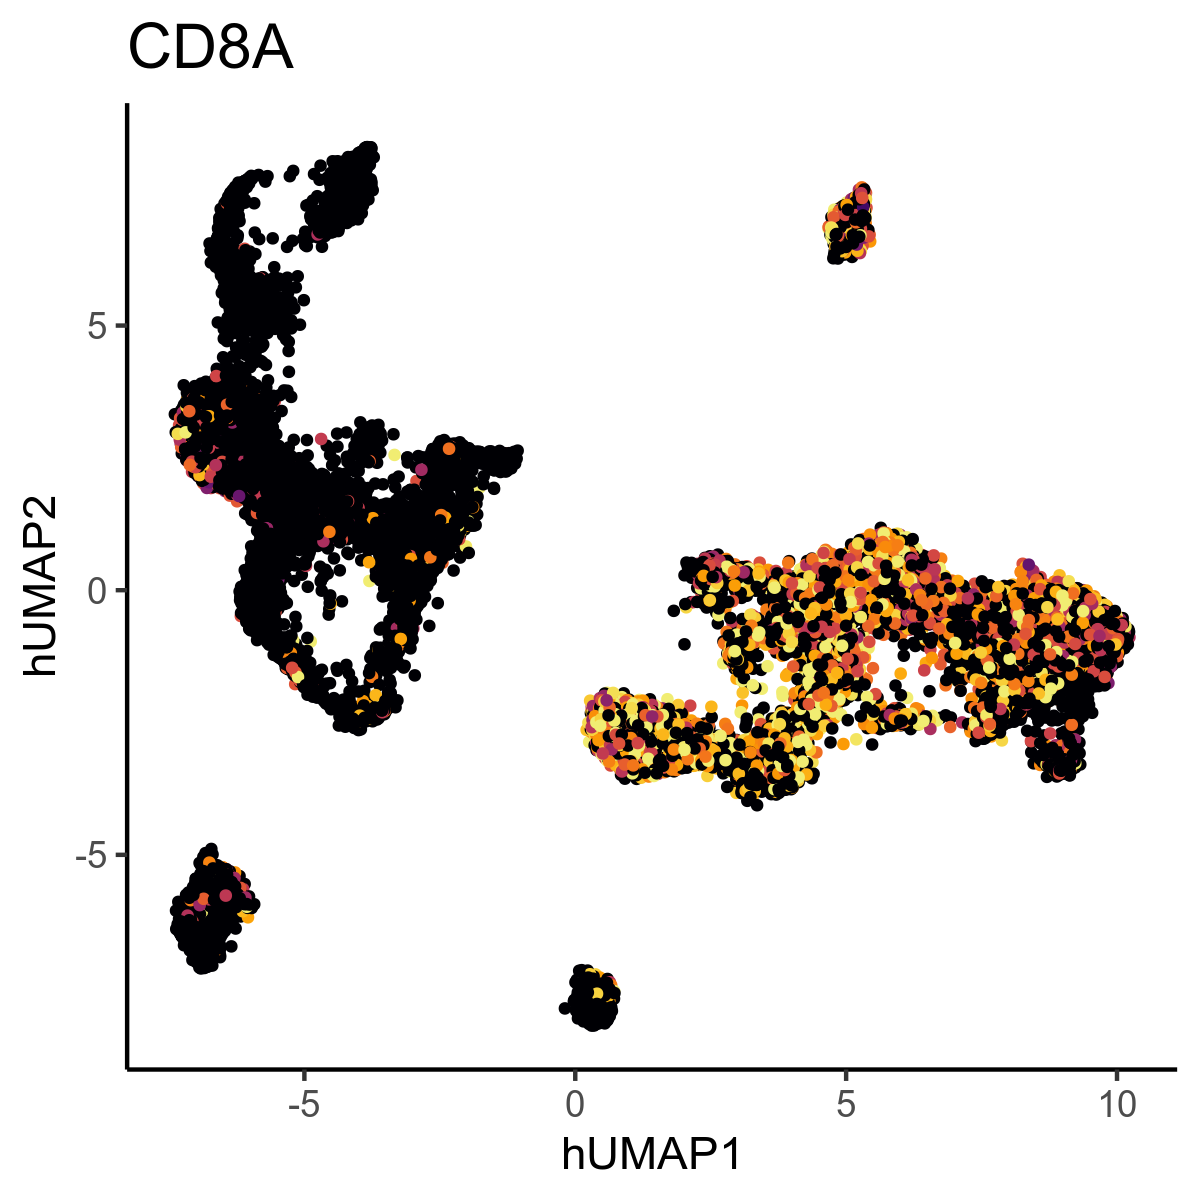

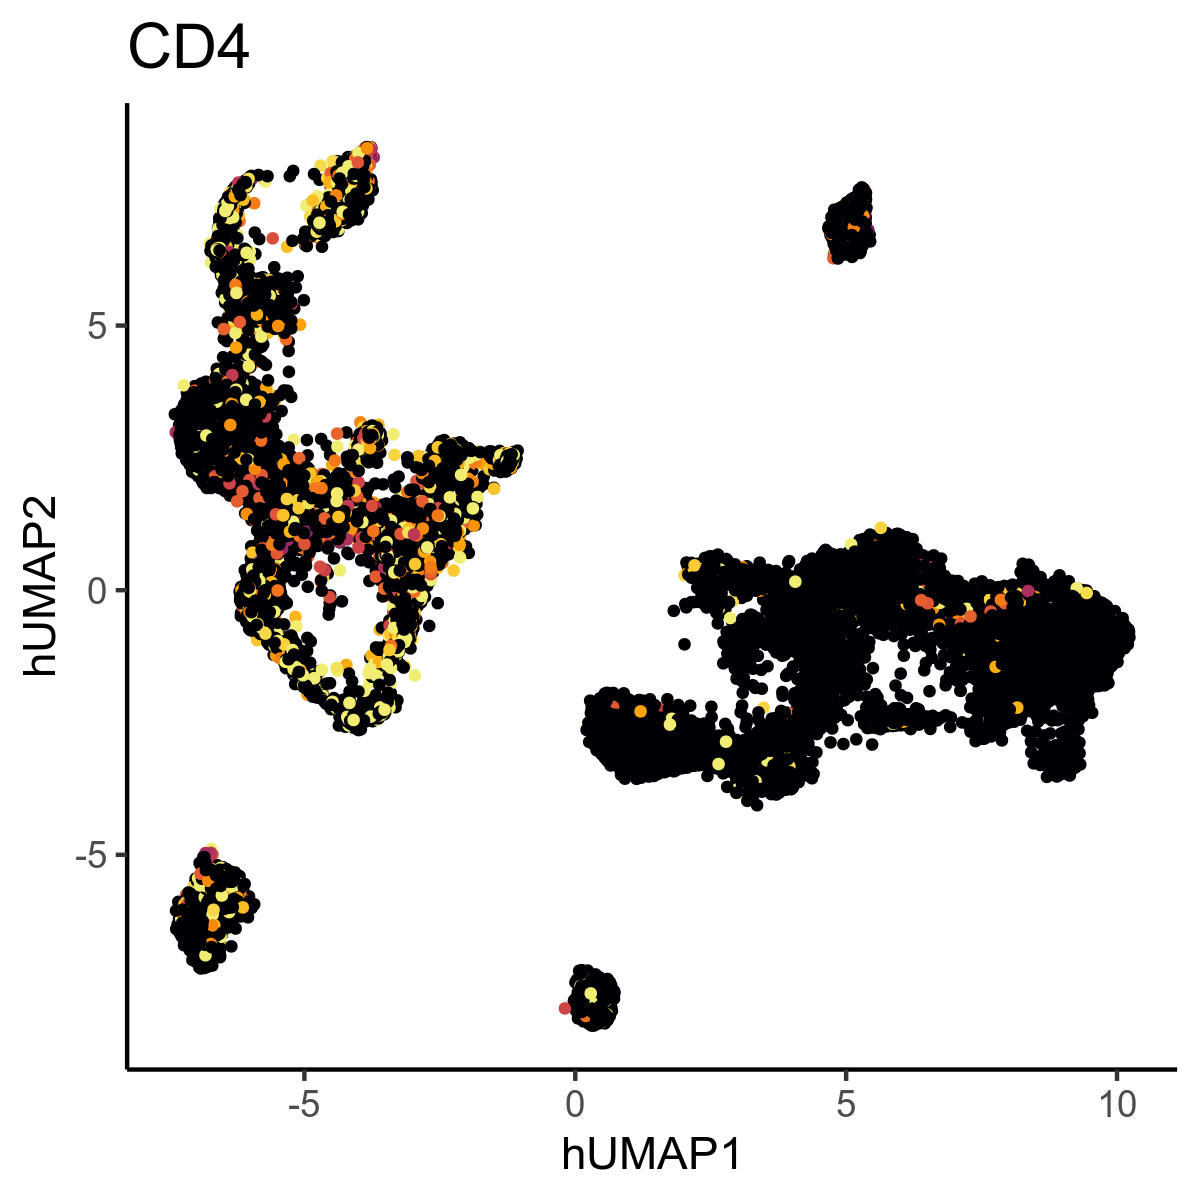

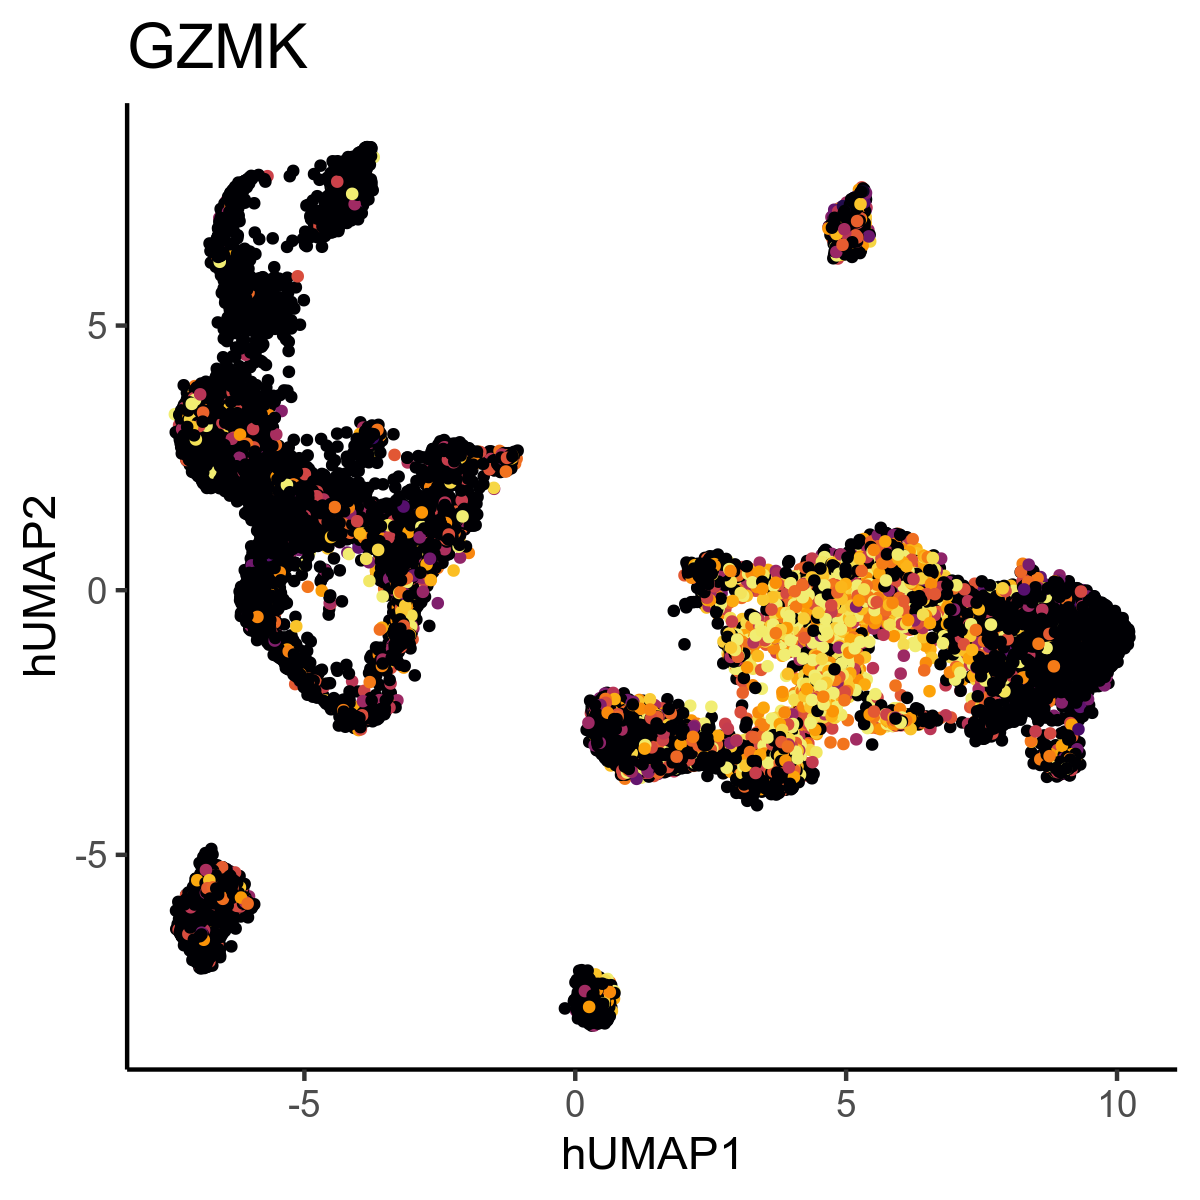

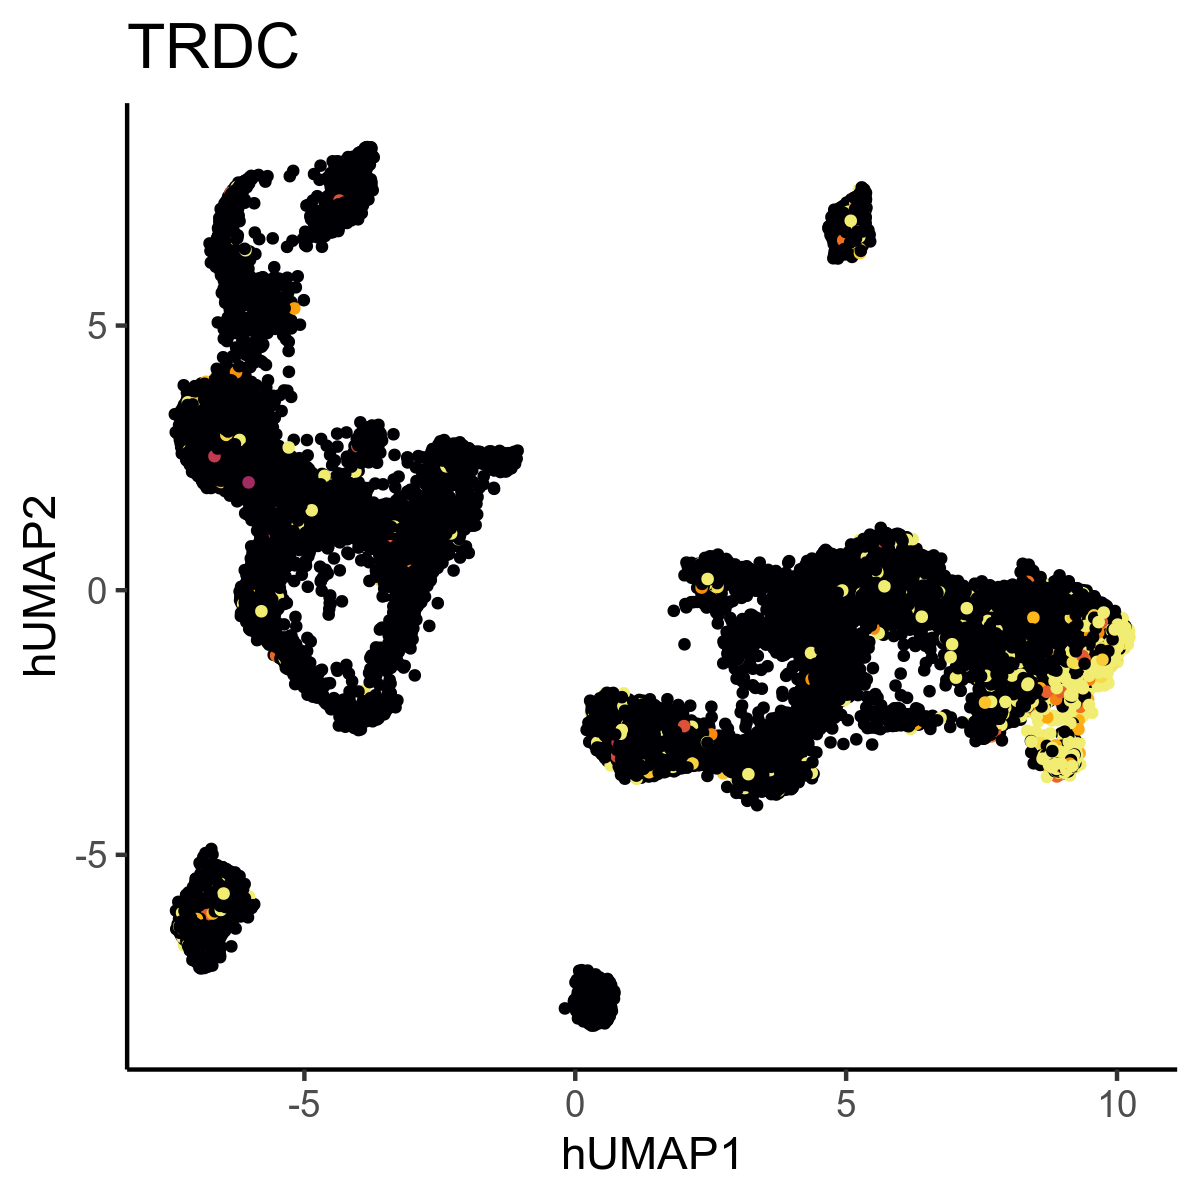

In [39]:
plot_shuffled_features('CD3D', qcd_meta %>% select(hUMAP1, hUMAP2) %>% rename(V1 = hUMAP1, V2 = hUMAP2), 
                       qcd_norm, 0.95)
plot_shuffled_features('GZMB', qcd_meta %>% select(hUMAP1, hUMAP2) %>% rename(V1 = hUMAP1, V2 = hUMAP2), 
                       qcd_norm, 0.95)
plot_shuffled_features('CD8A', qcd_meta %>% select(hUMAP1, hUMAP2) %>% rename(V1 = hUMAP1, V2 = hUMAP2), 
                       qcd_norm, 0.95)
plot_shuffled_features('CD4', qcd_meta %>% select(hUMAP1, hUMAP2) %>% rename(V1 = hUMAP1, V2 = hUMAP2), 
                       qcd_norm, 0.95)
plot_shuffled_features('GZMK', qcd_meta %>% select(hUMAP1, hUMAP2) %>% rename(V1 = hUMAP1, V2 = hUMAP2), 
                       qcd_norm, 0.95)
plot_shuffled_features('TRDC', qcd_meta %>% select(hUMAP1, hUMAP2) %>% rename(V1 = hUMAP1, V2 = hUMAP2), 
                       qcd_norm, 0.95)

In [4]:
qcd_meta <- left_join(qcd_meta, qcd_meta %>% 
            group_by(hres0.2) %>% 
            summarize(umap_mean = mean(hUMAP1)) %>% 
            arrange(desc(umap_mean)) %>% 
            mutate(new_cluster_number = 0:17) %>% select(- umap_mean))

Joining, by = "hres0.2"


Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”


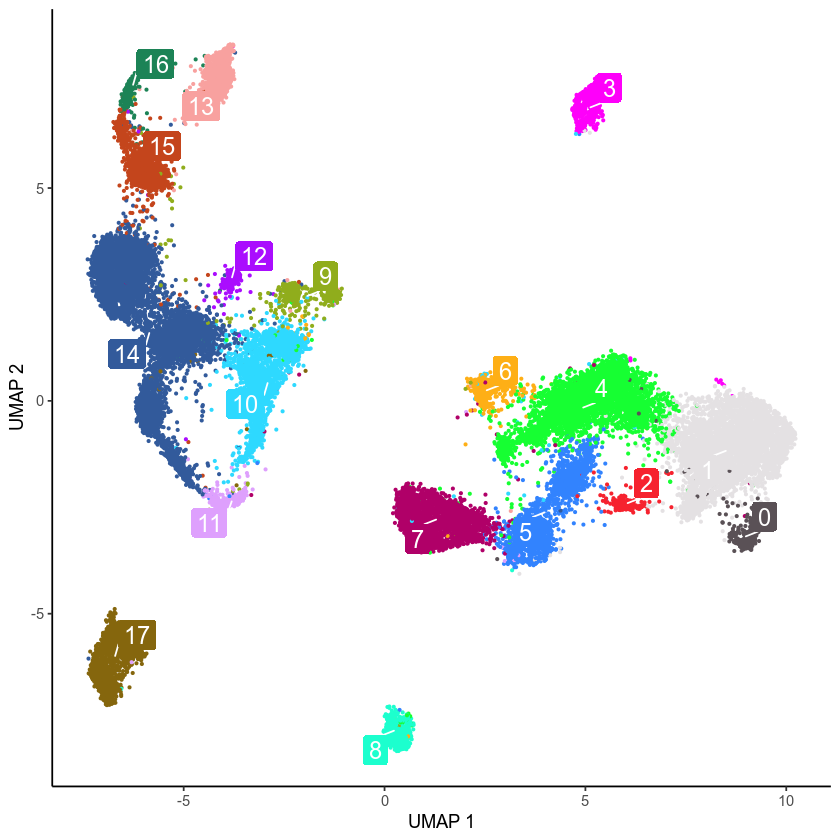

In [8]:
plot_clusters3(qcd_meta$new_cluster_number, qcd_meta$new_cluster_number, 
               umap_use = qcd_meta %>% select(hUMAP1, hUMAP2), 
               do_labels = TRUE) + 
        scale_color_manual(values = as.vector(polychrome(26))) +
    scale_fill_manual(values = as.vector(polychrome(26)))

Joining, by = "cell"
Joining, by = "cell"
Joining, by = "cell"
Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”
Warning message:
“Removed 1 rows containing missing values (geom_label_repel).”


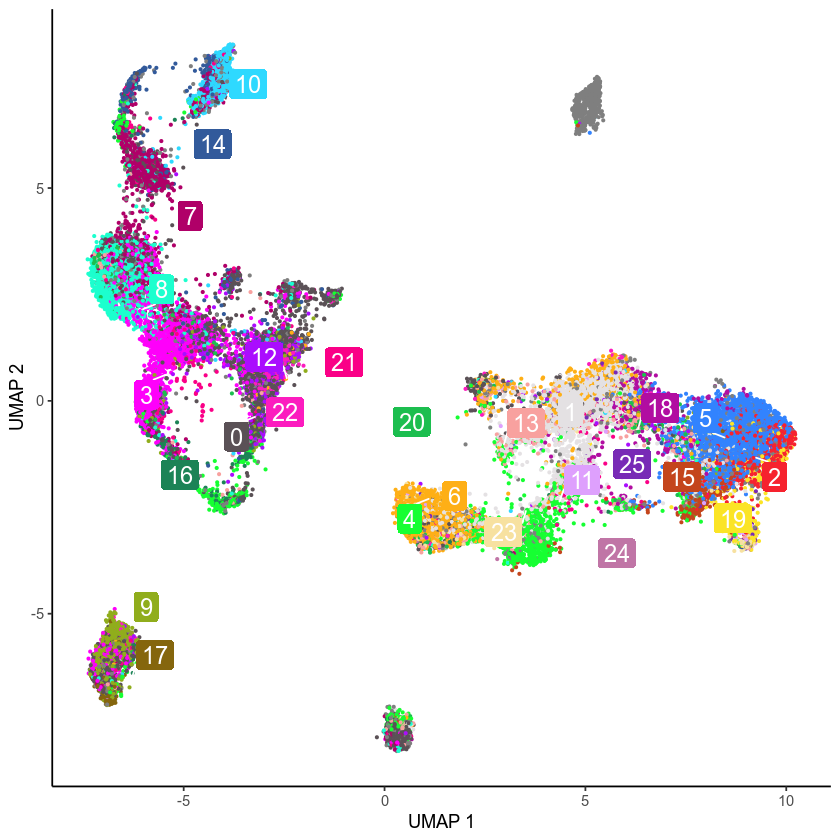

In [41]:
plot_clusters3(left_join(qcd_meta, arnon_clusters) %>% pull(arnon_cluster), 
               left_join(qcd_meta, arnon_clusters) %>% pull(arnon_cluster), 
               umap_use = left_join(qcd_meta, arnon_clusters) %>% select(hUMAP1, hUMAP2), 
               do_labels = TRUE) + 
    scale_color_manual(values = as.vector(polychrome(26))) +
    scale_fill_manual(values = as.vector(polychrome(26)))

In [9]:
wilcox <- wilcoxauc(qcd_norm, qcd_meta$new_cluster_number)

Warning message:
“Removed 22 rows containing non-finite values (stat_boxplot).”


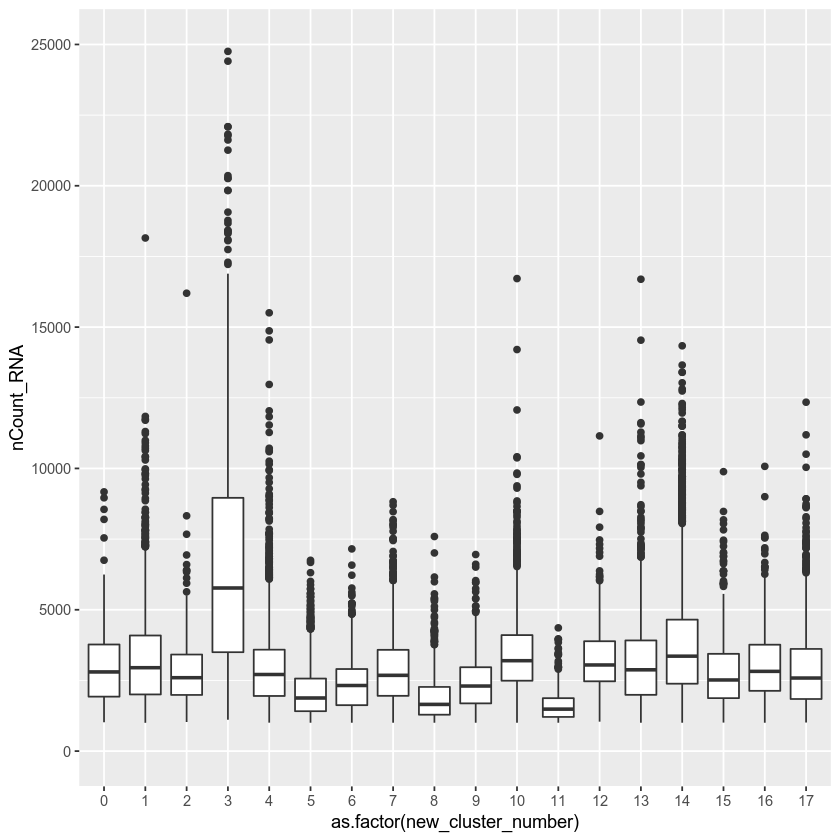

Warning message:
“Removed 3 rows containing non-finite values (stat_boxplot).”


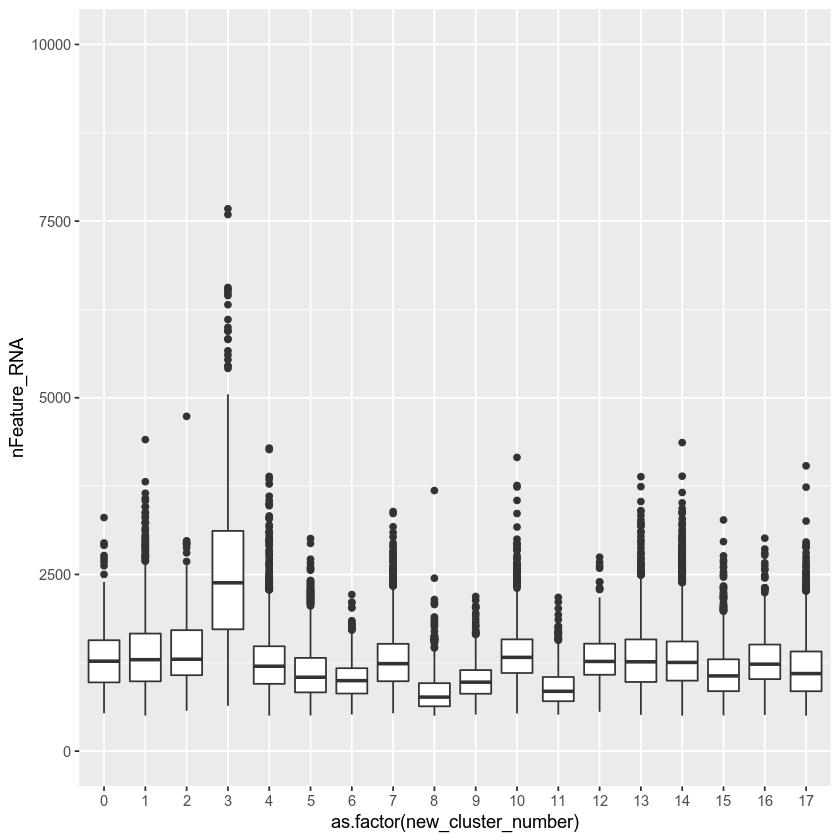

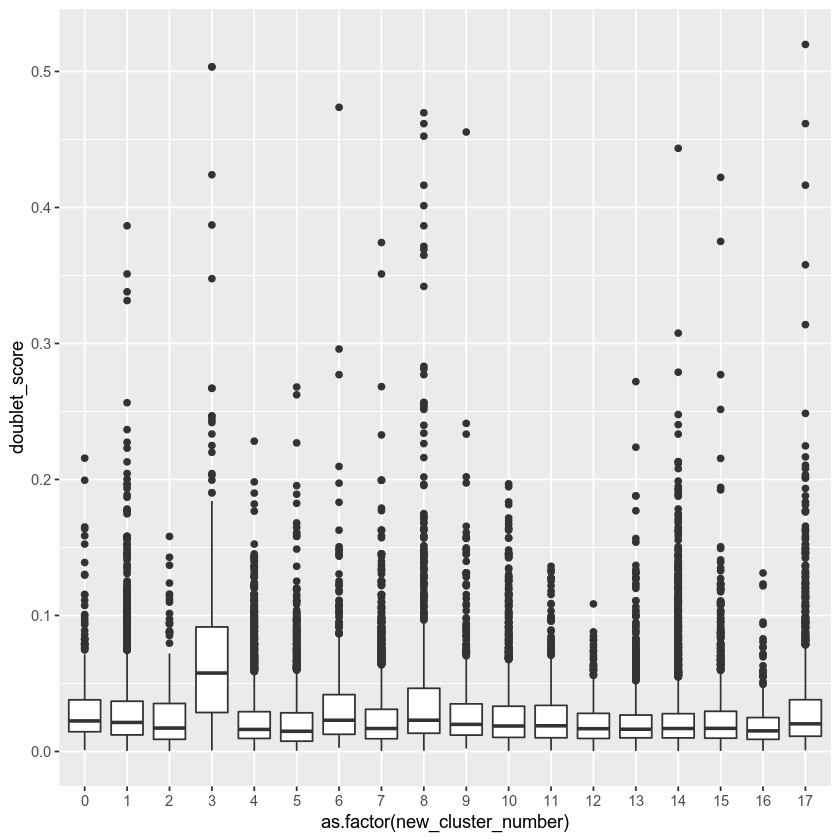

In [91]:
ggplot(qcd_meta, aes(x = as.factor(new_cluster_number), y = nCount_RNA)) + 
    geom_boxplot() + 
    scale_y_continuous(limits = c(0, 25000))

ggplot(qcd_meta, aes(x = as.factor(new_cluster_number), y = nFeature_RNA)) + 
    geom_boxplot() + 
    scale_y_continuous(limits = c(0, 10000))

ggplot(qcd_meta, aes(x = as.factor(new_cluster_number), y = doublet_score)) + 
    geom_boxplot() 

In [11]:
rawcounts <- readRDS('/data/srlab2/qxiao/AMP-SLE/sc_nuc_data/2022-08-09_ScNuc_cell_QCed_RawCounts.rds')
mito_genes_subset <- c("MT-ND5", "MT-ND6")
percent_mito <- colSums(rawcounts[mito_genes_subset, ]) / colSums(rawcounts) * 100
percent_mito <- data.frame(cell = names(percent_mito), percent.mt = percent_mito)

In [12]:
ribo_genes_subset <- c(grep('RPL', rownames(rawcounts), value = TRUE), grep('RPS', rownames(rawcounts), value = TRUE))
percent_ribo <- colSums(rawcounts[ribo_genes_subset, ]) / colSums(rawcounts) * 100
percent_ribo<- data.frame(cell = names(percent_ribo), percent.ribo = percent_ribo)

In [13]:
qcd_meta <- left_join(qcd_meta, percent_mito)

Joining, by = "cell"


In [14]:
qcd_meta <- left_join(qcd_meta, percent_ribo)

Joining, by = "cell"


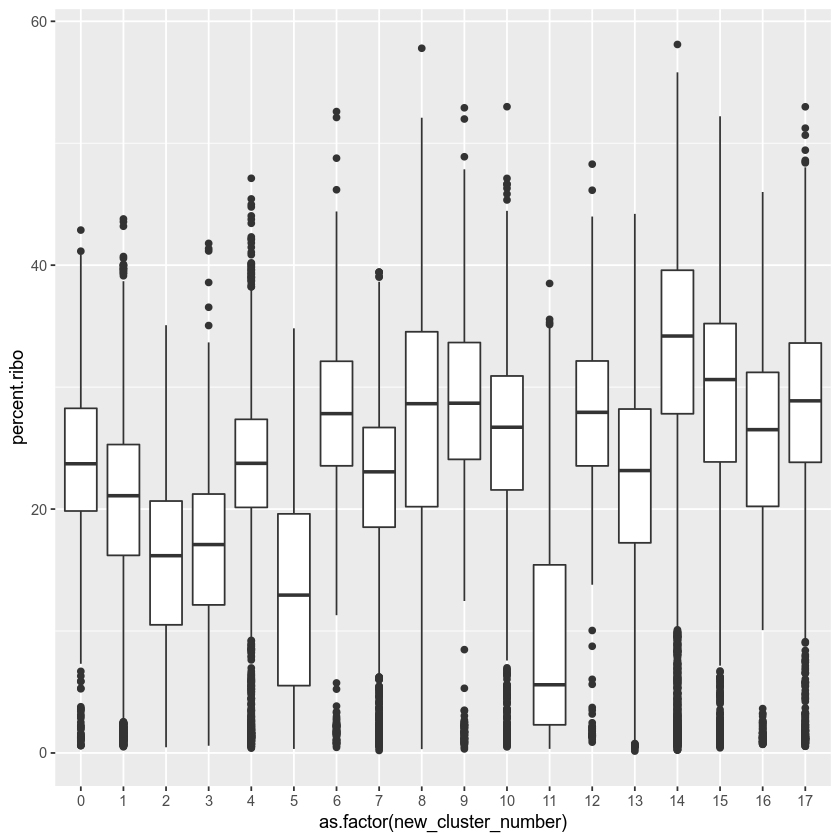

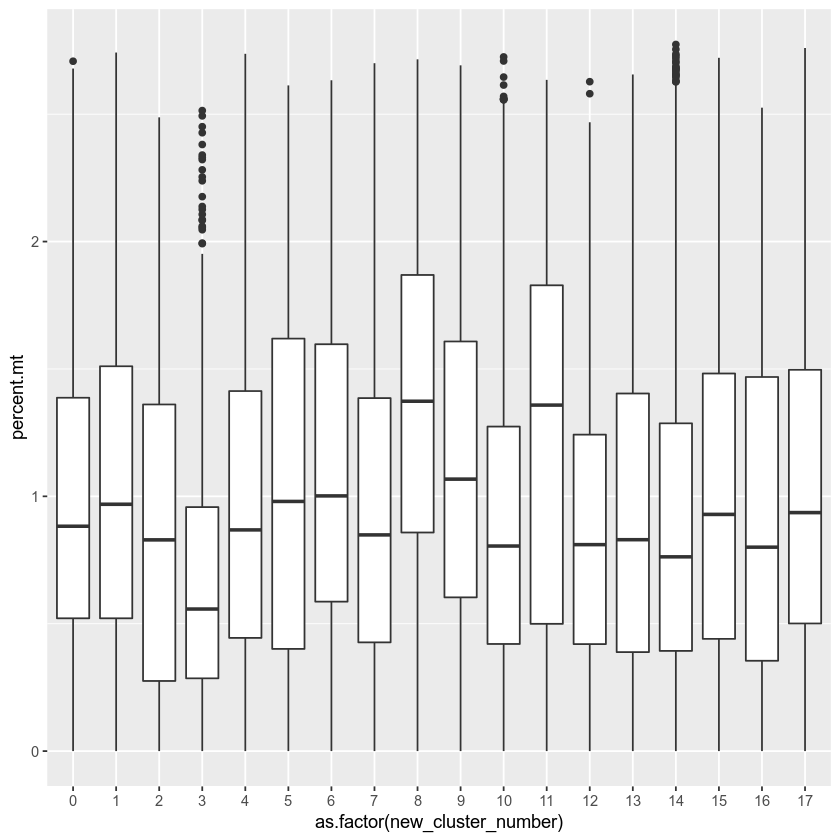

In [15]:
ggplot(qcd_meta, aes(x = as.factor(new_cluster_number), y = percent.ribo)) +
    geom_boxplot()
ggplot(qcd_meta, aes(x = as.factor(new_cluster_number), y = percent.mt)) +
    geom_boxplot()

In [14]:
annotations <- c('T0. TRDC+ CD4- CD8-', 'T1. CD8+ GZMB+', 'T2. CD8+ GZMK+ SYNEhi', 
                 'T3. CENPF MKI67+ Proliferating', 'T4. CD8+ GZMK+ CCL4hi CCL5hi', 'T5. CD8+ GZMK+ SYNElo',
                 'T6. CD8+ GZMK+ CCL4lo CCL5lo', 'T7. CD8+ ZNF683+', 'T8. MT-high', 'T9. CD4+ CD40LG+ Ribohi',
                 'T10. CD4+ CD69hi ITGAE+', 'T11. low quality', 'T12. CD4+ CD69+ ITGAElo', 'T13. CD4+ IL2RA+ FOXP3+',
                 'T14. CD4+ KLF2hi LTBhi', 'T15. CD4+ SELLhi LEF1hi', 'T16. CD4+ PDCD1+ CXCR5+', 'T17. CD4+ KLRB1+ RORC+ CCR6+')
annotation <- data.frame(new_cluster_number = 0:17, annotation = annotations)
qcd_meta <- qcd_meta  %>% left_join(annotation)

Joining, by = "new_cluster_number"


In [17]:
arnon_annot <- readRDS('/data/srlab2/jmears/jupyter/SLE_Phase2_Kidney_Analysis/Final-Arnon-Output/all_T+NK_cells.w_clustering.rds')
arnon_annotations <- c('0. Res. Mem. CD4', '1. GZMK CD8', '2. CD56dim NK', '3. Non Res. Mem. CD4', '4. GZMK CD8 (low quality)',
                       '5. CTLs', '6. Res. Mem CD8', '7. Non. Res. Mem CD4', '8. DP T', '9. Th17', '10. Tregs', '11. CD56brightNK' , 
                       '12. Th1', '13. GZMK CD8', '14. TFH', '15. CTLs', '16. CD4 (low quality)', '17. ILCs', '18. GZMK CD8', 
                       '19. gamma/delta', '20. GZMK CD8', '21. ISG High', '22. Th1', '23. gamma/delta', '24. CD56bright NK', 
                       '25. High Producers')
arnon_clusters <- data.frame(cell = names(arnon_annot@active.ident), 
                             arnon_cluster = arnon_annot@active.ident)

arnon_clusters <- left_join(arnon_clusters, data.frame(arnon_cluster = as.factor(0:25), arnon_annotations = arnon_annotations))

Joining, by = "arnon_cluster"


In [29]:
arnon_vs_sid <- qcd_meta %>% left_join(arnon_clusters) %>% filter(dataset == 'scRNAseq') %>% select(annotation, arnon_annotations) %>% na.omit() %>% 
                                            group_by(annotation, arnon_annotations) %>% tally()

Joining, by = "cell"


In [30]:
df <- ungroup(arnon_vs_sid)
statistic <- vector()
for (i in 1:nrow(df)) {
        inAandB <- df %>% filter(annotation == arnon_vs_sid$annotation[i], 
                                           arnon_annotations == arnon_vs_sid$arnon_annotations[i]) %>% pull(n) %>% sum()
        inAnotB <- df %>% filter(annotation == arnon_vs_sid$annotation[i], 
                                           arnon_annotations != arnon_vs_sid$arnon_annotations[i]) %>% pull(n) %>% sum()
        inBnotA <- df %>% filter(annotation != arnon_vs_sid$annotation[i], 
                                           arnon_annotations == arnon_vs_sid$arnon_annotations[i]) %>% pull(n) %>% sum()
        notBnotA <- df %>% filter(annotation != arnon_vs_sid$annotation[i], 
                                            arnon_annotations != arnon_vs_sid$arnon_annotations[i]) %>% pull(n) %>% sum()
        contin <- data.frame(c(inAandB, inAnotB), c(inBnotA, notBnotA))
        or <- (contin[1, 1] * contin[2, 2]) / (contin[1, 2] * contin[2, 1])
        statistic <- c(statistic, sign(log(or)) * sqrt(chisq.test(contin, simulate.p.value = TRUE)$statistic))        
}

In [31]:
df$stat <- statistic

In [32]:
or_plot <- df %>% select(-n) %>% pivot_wider(names_from = 'annotation', values_from = 'stat') 
cols <- colnames(or_plot)
or_plot[is.na(or_plot)] <- 0 
or_plot <- or_plot %>% data.frame()
rownames(or_plot) <- or_plot$arnon_annot
colnames(or_plot) <- cols
or_plot <- or_plot[, -1]

In [33]:
library(dendsort)
sort_hclust <- function(...) as.hclust(dendsort(as.dendrogram(...)))

mat_cluster_cols <- hclust(dist(t(or_plot)))

mat_cluster_cols <- sort_hclust(mat_cluster_cols)

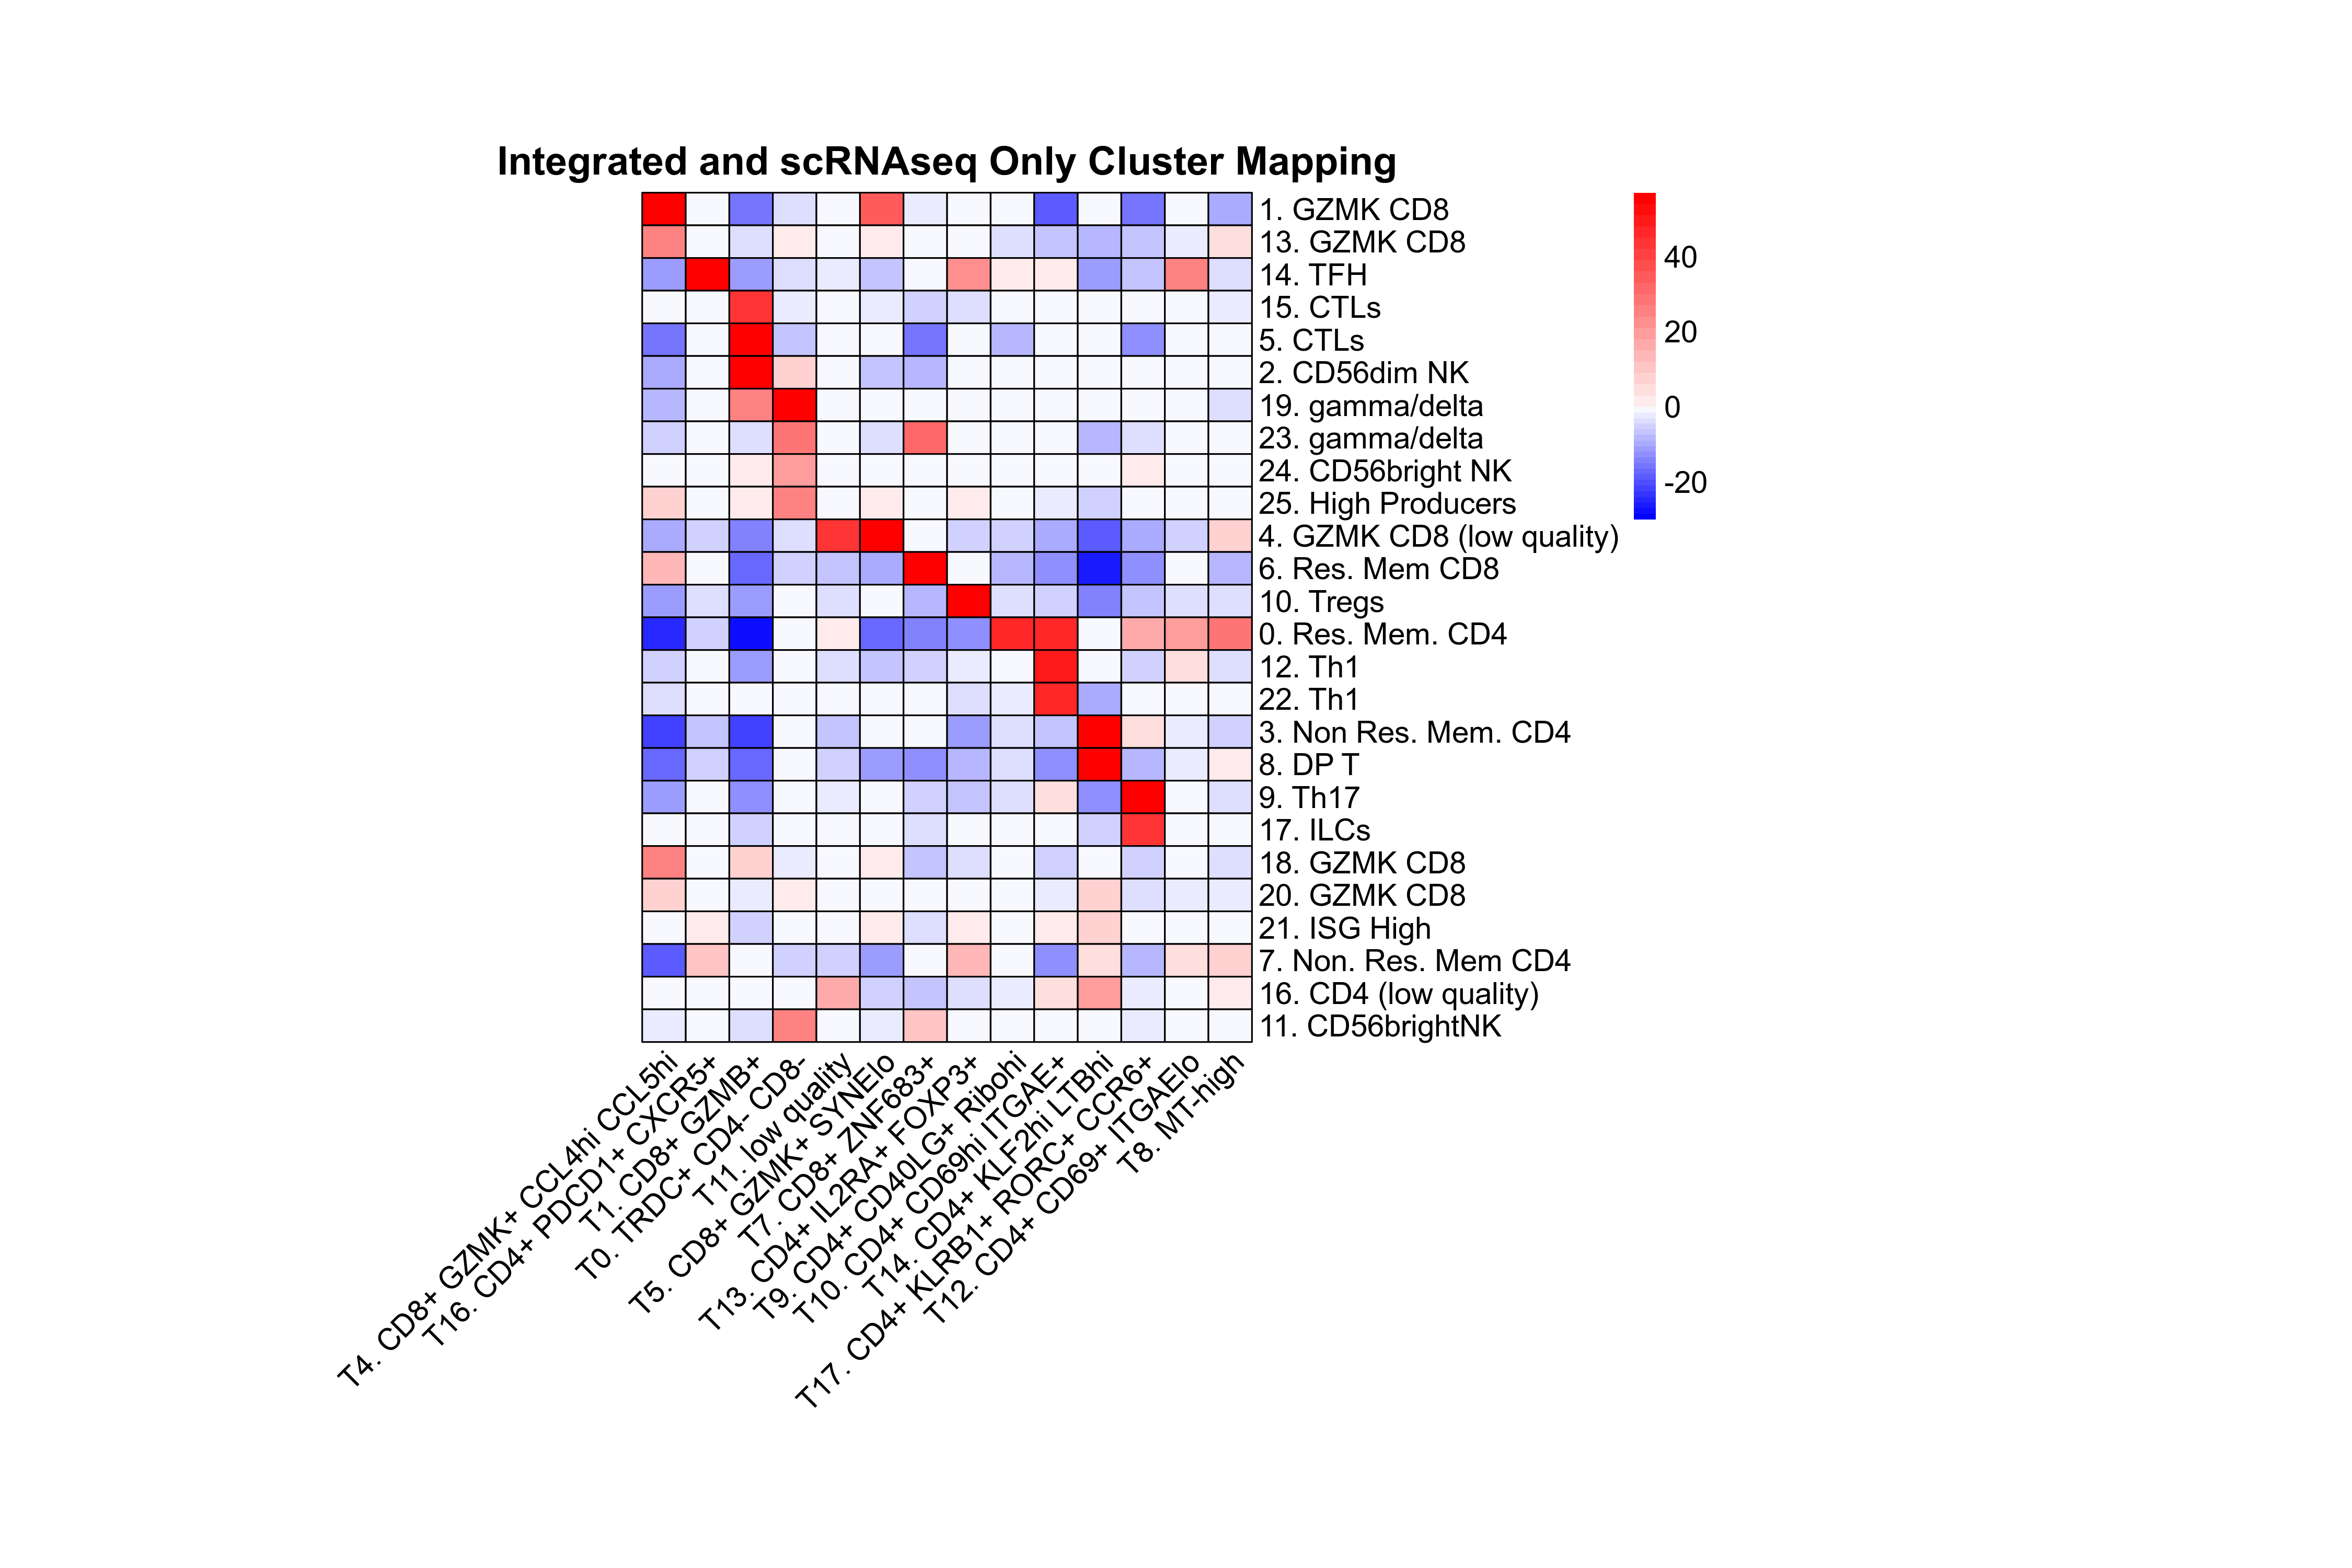

In [77]:
fig.size(10, 15)
pheatmap::pheatmap(or_plot[row.order, col.order], cellwidth = 20, cellheight = 15, 
                   color=colorRampPalette(c("blue", "white", "red"))(40), 
                   breaks = c(seq(-30, 0, 1.5), seq(0.001, 60, 3)), 
                   border_color = 'black', scale = 'none', cluster_rows = FALSE, 
                   cluster_cols = FALSE, main = 'Integrated and scRNAseq Only Cluster Mapping', fontsize = 14, angle_col = 45)

In [74]:
row.order <- c('1. GZMK CD8', '13. GZMK CD8', '14. TFH', '15. CTLs', '5. CTLs', 
               '2. CD56dim NK', '19. gamma/delta', '23. gamma/delta', 
               '24. CD56bright NK', '25. High Producers', '4. GZMK CD8 (low quality)', '6. Res. Mem CD8',
               '10. Tregs', '0. Res. Mem. CD4', '12. Th1', '22. Th1', '3. Non Res. Mem. CD4', '8. DP T', '9. Th17', 
                '17. ILCs', '18. GZMK CD8', '20. GZMK CD8', '21. ISG High',
               '7. Non. Res. Mem CD4', '16. CD4 (low quality)', '11. CD56brightNK')

In [52]:
rownames(or_plot)[!rownames(or_plot) %in% row.order]

[1] "11. CD56brightNK"      "17. ILCs"              "18. GZMK CD8"         
 [4] "2. CD56dim NK"         "20. GZMK CD8"          "21. ISG High"         
 [7] "6. Res. Mem CD8"       "7. Non. Res. Mem CD4"  "10. Tregs"            
[10] "16. CD4 (low quality)"

In [49]:
rownames(or_plot)

[1] "1. GZMK CD8"               "11. CD56brightNK"         
 [3] "13. GZMK CD8"              "14. TFH"                  
 [5] "15. CTLs"                  "17. ILCs"                 
 [7] "18. GZMK CD8"              "19. gamma/delta"          
 [9] "2. CD56dim NK"             "20. GZMK CD8"             
[11] "21. ISG High"              "23. gamma/delta"          
[13] "24. CD56bright NK"         "25. High Producers"       
[15] "4. GZMK CD8 (low quality)" "5. CTLs"                  
[17] "6. Res. Mem CD8"           "7. Non. Res. Mem CD4"     
[19] "0. Res. Mem. CD4"          "10. Tregs"                
[21] "12. Th1"                   "3. Non Res. Mem. CD4"     
[23] "8. DP T"                   "9. Th17"                  
[25] "16. CD4 (low quality)"     "22. Th1"

In [76]:
col.order <- c('T4. CD8+ GZMK+ CCL4hi CCL5hi', 'T16. CD4+ PDCD1+ CXCR5+', 'T1. CD8+ GZMB+',
               'T0. TRDC+ CD4- CD8-', 'T11. low quality', 'T5. CD8+ GZMK+ SYNElo', 
               'T7. CD8+ ZNF683+', 
               'T13. CD4+ IL2RA+ FOXP3+', 'T9. CD4+ CD40LG+ Ribohi', 'T10. CD4+ CD69hi ITGAE+', 'T14. CD4+ KLF2hi LTBhi', 
               'T17. CD4+ KLRB1+ RORC+ CCR6+', 'T12. CD4+ CD69+ ITGAElo', 'T8. MT-high')

## SYMPHONY

In [6]:
ref <- readRDS("/data/srlab1/public/srcollab/AMP_Phase_2/singlecell_result/T_reference_2020-11-25.rds")
ref$save_uwot_path <- '/data/srlab1/public/srcollab/AMP_Phase_2/singlecell_result/T_uwot_model_2020-11-25'

In [7]:
remove_cells <-which(is.na(ref$meta_data[, 'cluster_name']))

In [8]:
ref$meta_data[remove_cells, 'cluster_name'] = 'NaN'

In [15]:
query = mapQuery(qcd_norm[, qcd_meta %>% filter(dataset == 'scRNAseq') %>% pull(cell)], # query gene expression (genes x cells)
                    qcd_meta %>% filter(dataset == 'scRNAseq'),        # query metadata (cells x attributes)
                    ref, # Symphony reference object
                    do_normalize = FALSE,  # perform log(CP10k) normalization on query
                    vars = c("sample", "processing.batch"),
                    do_umap = TRUE)        # project query cells into reference UMAP

Scaling and synchronizing query gene expression

Found 5061 out of 5179 reference variable genes in query dataset

Project query cells using reference gene loadings

Clustering query cells to reference centroids

Correcting query batch effects

UMAP

All done!



In [16]:
query = knnPredict(query, ref, ref$meta_data[ ,"cluster_name"], k = 5, confidence=TRUE)

In [17]:
plot_df <- query$meta_data
plot_df <- cbind(plot_df, data.frame(query$umap))
plot_df <- plot_df %>% filter(cell_type_pred_knn_prob > 0.6) 

In [18]:
cell_type <- plot_df %>%  select(annotation, cell_type_pred_knn) %>% 
                                group_by(annotation, cell_type_pred_knn) %>% tally()

In [19]:
df <- ungroup(cell_type)
or <- vector()
statistic <- vector() 
for (i in 1:nrow(df)) {
        inAandB <- df %>% filter(annotation == df$annotation[i], 
                                           cell_type_pred_knn == df$cell_type_pred_knn[i]) %>% pull(n) %>% sum()
        inAnotB <- df %>% filter(annotation == df$annotation[i], 
                                           cell_type_pred_knn != df$cell_type_pred_knn[i]) %>% pull(n) %>% sum()
        inBnotA <- df %>% filter(annotation != df$annotation[i], 
                                           cell_type_pred_knn == df$cell_type_pred_knn[i]) %>% pull(n) %>% sum()
        notBnotA <- df %>% filter(annotation != df$annotation[i], 
                                           cell_type_pred_knn != df$cell_type_pred_knn[i]) %>% pull(n) %>% sum()
        contin <- data.frame(c(inAandB, inAnotB), c(inBnotA, notBnotA))
        or <- (contin[1, 1] * contin[2, 2]) / (contin[1, 2] * contin[2, 1])
        statistic <- c(statistic, sign(log(or)) * sqrt(chisq.test(contin, simulate.p.value = TRUE)$statistic))        
}

df$stat <- statistic

or_plot <- df %>% select(-n) %>% pivot_wider(names_from = 'annotation', values_from = 'stat') 
cols <- colnames(or_plot)
or_plot[is.na(or_plot)] <- 0 
or_plot <- or_plot %>% data.frame()
rownames(or_plot) <- or_plot$cell_type_pred_knn
colnames(or_plot) <- cols
or_plot <- or_plot[, -1]

In [ ]:
row.order <- c('CD38+','CD4+ CD146+ memory','CD4+ CD161+ memory','CD4+ GNLY+','CD4+ GZMK+ memory','CD4+ IL7R+ memory','CD4+ IL7R+CCR5+ memory','CD4+ memory','CD4+ naive','CD4+ Tfh/Tph','CD8+ CD45ROlow/naive','CD8+ GZMB+/TEMRA','CD8+ GZMK/B+ memory','CD8+ GZMK+ memory','Innate-like','MT-high (low quality)','Vdelta1','Vdelta2','CD4+ CD25-high Treg','CD4+ CD25-low Treg','CD4+ OX40+NR3C1+','CD4+ Tph','CD8+ activated/NK-like','Proliferating')

In [26]:
col.order <- c('T3. CENPF MKI67+ Proliferating', 'T17. CD4+ KLRB1+ RORC+ CCR6+', 
               'T10. CD4+ CD69hi ITGAE+', 'T14. CD4+ KLF2hi LTBhi', 
               'T1. CD8+ GZMB+', 'T5. CD8+ GZMK+ SYNElo', 'T4. CD8+ GZMK+ CCL4hi CCL5hi', 
               'T16. CD4+ PDCD1+ CXCR5+', 'T12. CD4+ CD69+ ITGAElo', 
               'T7. CD8+ ZNF683+','T0. TRDC+ CD4- CD8-',  'T13. CD4+ IL2RA+ FOXP3+', 'T15. CD4+ SELLhi LEF1hi', 
               colnames(or_plot)[- which(colnames(or_plot) %in% col.order)])

In [25]:
colnames(or_plot)[- which(colnames(or_plot) %in% col.order)]

[1] "T11. low quality"             "T2. CD8+ GZMK+ SYNEhi"       
[3] "T6. CD8+ GZMK+ CCL4lo CCL5lo" "T8. MT-high"                 
[5] "T9. CD4+ CD40LG+ Ribohi"

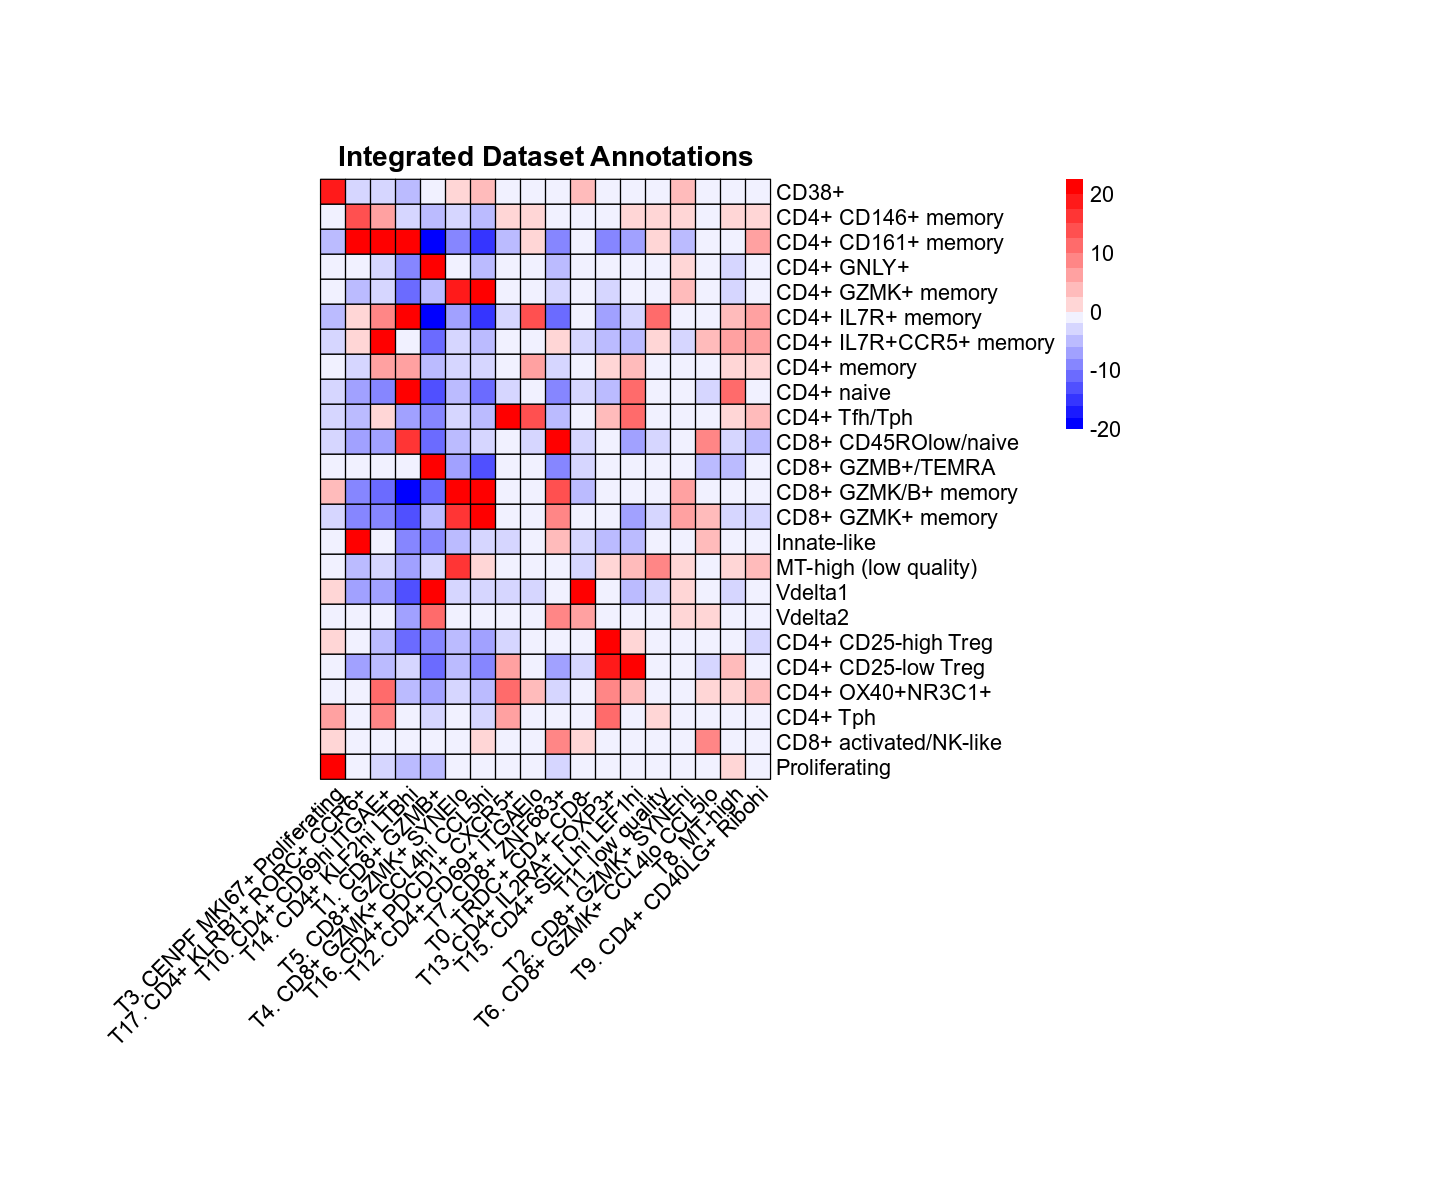

In [27]:
fig.size(10, 12)
pheatmap::pheatmap(or_plot[row.order, col.order], cellwidth = 15, cellheight = 15, 
                   color=colorRampPalette(c("blue", "white", "red"))(20), 
                   breaks = c(seq(-20, 0, 2), seq(0.001, 25, 2.5)), border_color = 'black', scale = 'none',
                   cluster_cols = FALSE, cluster_rows = FALSE, main = 'Integrated Dataset Annotations', fontsize = 13, angle_col = 45)

In [89]:
colnames(or_plot)

[1] "T0. TRDC+ CD4- CD8-"            "T1. CD8+ GZMB+"                
 [3] "T10. CD4+ CD69hi ITGAE+"        "T11. low quality"              
 [5] "T12. CD4+ CD69+ ITGAElo"        "T13. CD4+ IL2RA+ FOXP3+"       
 [7] "T14. CD4+ KLF2hi LTBhi"         "T15. CD4+ SELLhi LEF1hi"       
 [9] "T16. CD4+ PDCD1+ CXCR5+"        "T17. CD4+ KLRB1+ RORC+ CCR6+"  
[11] "T2. CD8+ GZMK+ SYNEhi"          "T3. CENPF MKI67+ Proliferating"
[13] "T4. CD8+ GZMK+ CCL4hi CCL5hi"   "T5. CD8+ GZMK+ SYNElo"         
[15] "T6. CD8+ GZMK+ CCL4lo CCL5lo"   "T7. CD8+ ZNF683+"              
[17] "T8. MT-high"                    "T9. CD4+ CD40LG+ Ribohi"